<a href="https://colab.research.google.com/github/ahshawaf/AML/blob/project6/Project6_Team1_B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://cdn.educba.com/academy/wp-content/uploads/2019/10/Unsupervised-Machine-Learning.jpg)

Unsupervised learning is a type of machine learning algorithm used to draw inferences from datasets consisting of input data without labeled responses. The most common unsupervised learning method is cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data. Within this experiment, the datasets (image type) and machine learning techniques are described below.

**Image Datasets:**


*   Bridge: 4x4 pixel blocks of bridge images, contained 4096 pixel blocks as txt file.   
http://cs.joensuu.fi/sipu/datasets/ 
*   Coil-100: The dataset contains 7200 color images of 100 objects (72 images per object). Total file size is 124 MB.
https://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php

*   Celeb: CelebFaces Attributes Dataset (CelebA), with a total size 1.32 GB, is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including, 10,177 number of identities, 202,599 number of face images, and 5 landmark locations, 40 binary attributes annotations per image.   
http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
*   ImageNet: Images were collected variously on internet, come with two resolutions, 32x32 and 64x64, and total 1281149 images. 32x32 resolution with total size 3.83 GB is used in this assignment.  
http://image-net.org/small/download.php


**Machine Learning Techniques:** 


*   K-Means Clustering
*   RandomForest Classifier
*   GuassianMixture Classifier
*   Anomaly Detection Using GuassianMixture







#Setup

In [1]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os
import time
import random

import tarfile
import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(42)

from zipfile import ZipFile


from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'0.22.2.post1'

#Custom Functions

This is a fucntion to download a file using **URL**. Then save it in the **save_path** with **target_file_name**. If target_file_name is empty, then the file name will be gotten from the URL.

In [0]:
import urllib
import urllib.parse as parse

def download(url,save_path,target_file_name=''):
  print("file is being downloading from {} ...".format(url))
  file = urllib.request.urlopen(url)
  fileData = file.read()

  if target_file_name=='':
    split=parse.urlsplit(url)
    target_file_name = split.path.split('/')[-1]
  
  if not os.path.exists(save_path):
    os.mkdir(save_path)

  targetFile = os.path.join(save_path,target_file_name)
  with open(targetFile,'wb') as f:
    f.write(fileData)
  print('Done, file in the path {}'.format(targetFile))

This is a function to extract tar file in the **tar_file_path**, which includes the file name and the extension, to **target_path**.

In [0]:
def extractTar(tar_file_path,target_path):
    print("Extracting is starting....")
    tar=tarfile.open(tar_file_path)
    tar.extractall(target_path)
    tar.close()
    print("Done")

This is a function to extract zip file in the **zip_file_path**, which includes the file name and the extension, to **target_path**.

In [0]:
def extractZip(zip_file_path,target_path):
    print("Extracting is starting....")
    zFile=ZipFile(zip_file_path)
    zFile.extractall(target_path)
    zFile.close()
    print("Done")

This is a custom function to create a imgs set without labels, unsupervised dataset. It used the folder path of the imgs.

In [0]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path,img))
    img_imr = cv2.resize(img_imr,(32,32))
    x.append(np.array(img_imr))
  return x

randomly_sho_imgs is for randomly display nrows x ncols images from the training set 

In [0]:
def randomly_show_imgs(x_set,nrows,ncols):
  plt.figure(figsize=(10,10))
  for i in range(nrows*ncols):
    plt.subplot(nrows,ncols,i+1)
    indx = random.randint(0,len(x_set))
    plt.imshow(x_set[indx])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
  plt.show()

plot_data is to generate a plot chart from the x data

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

plot_centroids to generate a plot chart with the centers point passed

In [0]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

plot_decision_boundaries is to generate a Voronoi diagram:

In [0]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plot_gaussian_mixture is to generate a plot chart for gaussian_mixture

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

reduceTo2D fucntion is to reduce the dimensionality of dataset to 2D using t-SNE algorithm

In [0]:
from sklearn.manifold import TSNE

def reduceTo2D(dataset):
  tsne = TSNE(n_components=2,random_state=47)
  reduced_dataset=tsne.fit_transform(dataset)
  return reduced_dataset

getRandomSubset is a function a give a shuffled subset with a specific size. It is using train_test_split to generate the subset


In [0]:
def getRandomSubset(dataset, subset_size):
  subset_size_percentage = subset_size/len(dataset)
  x_train,x_test=train_test_split(dataset,test_size=subset_size_percentage,random_state=47,shuffle=True)
  print('subset {}'.format(x_test.shape))
  return x_test


create the following directeries to save the **downsampled and celeba datasets**

In [0]:
root_path = 'data'
if not os.path.exists(root_path):
  os.mkdir(root_path)

downsampled_path = os.path.join(root_path,'downsampled')
if not os.path.exists(downsampled_path):
  os.mkdir(downsampled_path)

celeba_path = os.path.join(root_path,'celeba')
if not os.path.exists(celeba_path):
  os.mkdir(celeba_path)

# Clustering Bridge Image Pixel Blocks

##Data Scrubing

## Loading Data

In [0]:
bridge = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/bridge.txt', delim_whitespace=True, header=None) #avoid spaces separated

In [15]:
bridge.head()

0   1   2   3   4   5   6   7   8   9   10  11  12  13   14   15
0   6   8   6   9   0   0   0   0   0   0   0   0   0   0    0    0
1   7   4   3   4   0   0   0   0   0   0   0   0   0   0    0    0
2   8   8   8  18  31  12  22  34  74  74  68  60  96  99  104   79
3   9   9  16  34  11  15  38  54  60  22  65  75  99  78   92  114
4   9  19  34  39  23  26  31  39  16  31  34  41  59  63   33   38

In [16]:
bridge.shape

(4096, 16)

In [17]:
bridge.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

Convert the bridge to numpy array.

In [0]:
bridge_np = np.array(bridge) #convert dataframe to numpy array

reshape data to orginal dimention to display the image

In [0]:
bridge4x4 = bridge_np.reshape(4096,4,4)

scale it by dividing it by 255 because the data is an image so the values between 0 and 255. So, divide the data the maxmimum value

In [0]:
bridge_np = bridge_np/255

In [21]:
bridge_np

array([[0.02352941, 0.03137255, 0.02352941, ..., 0.        , 0.        ,
        0.        ],
       [0.02745098, 0.01568627, 0.01176471, ..., 0.        , 0.        ,
        0.        ],
       [0.03137255, 0.03137255, 0.03137255, ..., 0.38823529, 0.40784314,
        0.30980392],
       ...,
       [0.98431373, 0.96862745, 0.95294118, ..., 0.49803922, 0.55294118,
        0.6       ],
       [0.98823529, 0.98039216, 0.97647059, ..., 0.36078431, 0.36862745,
        0.38823529],
       [0.99215686, 0.87843137, 0.81960784, ..., 0.96470588, 0.91372549,
        0.89019608]])

### Data Visualization

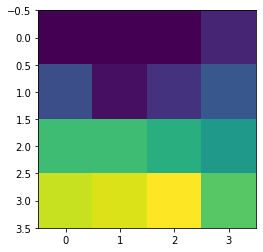

In [22]:
plt.imshow(bridge4x4[2]) #view the image index=2

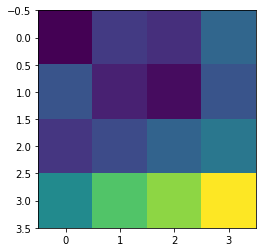

In [23]:
plt.imshow(bridge4x4[10]) #view the image index=10

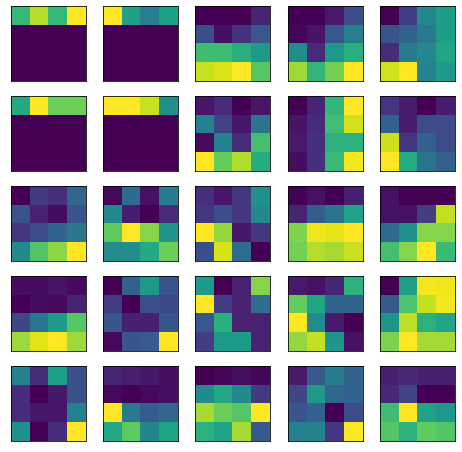

In [24]:
# See 25 images
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(bridge4x4[i])

Text(0.5, 1.0, 'Bridge Dataset')

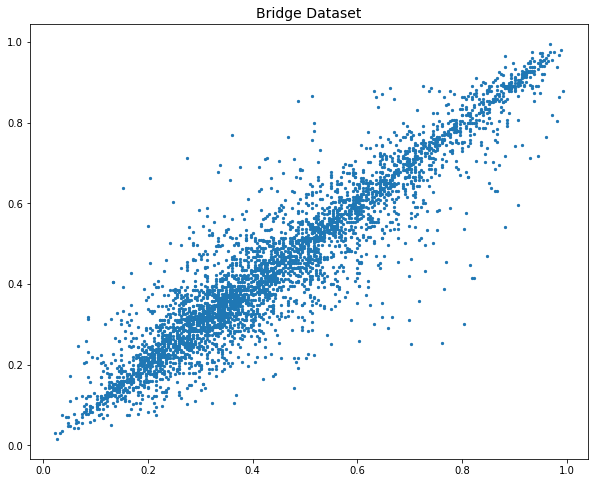

In [25]:
# See the whole dataset in 2d axis 
plt.figure(figsize=(10,8))
plt.scatter(bridge_np[:,0], bridge_np[:,1], s=5)
plt.title("Bridge Dataset", fontsize=14)

### Apply PCA (Variation = 99%)

In [26]:
pca = PCA(0.99)
X_bridge_pca = pca.fit_transform(bridge_np)
pca.n_components_

12

In [27]:
X_bridge_pca.shape

(4096, 12)

##K-means clustering

Choose random numbers of $k$ to find the best one

In [28]:
k_range = range(2,50)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_bridge_pca)
    kmeans_per_k.append(kmeans)

k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19
k=20
k=21
k=22
k=23
k=24
k=25
k=26
k=27
k=28
k=29
k=30
k=31
k=32
k=33
k=34
k=35
k=36
k=37
k=38
k=39
k=40
k=41
k=42
k=43
k=44
k=45
k=46
k=47
k=48
k=49


### Plot the silhouette score vs performance of $k$

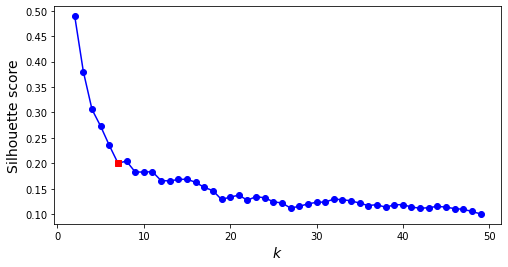

In [29]:
silhouette_scores = [silhouette_score(X_bridge_pca, model.labels_) for model in kmeans_per_k]
best_index = 5
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

###$k$=7 return the highest Sihouette score

In [30]:
best_k

7

##Plot K-Elbow

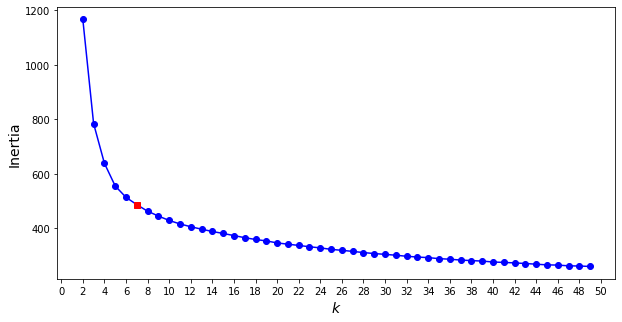

In [31]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.xticks(range(0,np.max(k_range)+2,2))
plt.show()

The elbow point is k=8

### Fit and Predict

In [0]:
kmodel = KMeans(n_clusters=best_k, random_state=42)

In [0]:
y_bridge = kmodel.fit_predict(X_bridge_pca)

In [34]:
len(y_bridge)

4096

In [35]:
y_bridge is kmodel.labels_

True

In [36]:
labels= np.unique(kmodel.labels_)
labels

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

Therefore, y (0,1) is the label that represents for each cluster.

###Plot K-means clusters

In [0]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=best_k, rseed=0, ax=None):

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=y_bridge, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[y_bridge == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

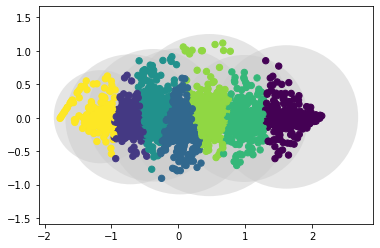

In [38]:
plot_kmeans(kmodel, X_bridge_pca)

In [39]:
X_bridge_2d = reduceTo2D(bridge_np)
X_bridge_2d.shape

(4096, 2)

In [40]:
kmodel2d = KMeans(n_clusters=best_k, random_state=42)
kmodel2d.fit(X_bridge_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

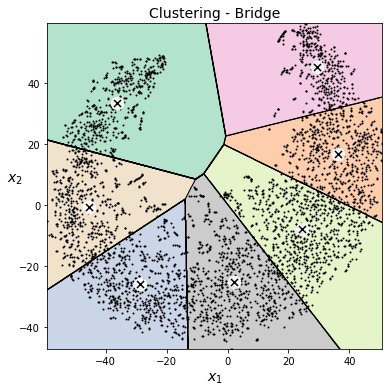

In [41]:
plt.figure(figsize=(6, 6))
plot_decision_boundaries(kmodel2d, X_bridge_2d)
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

##With RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_bridge_train, X_bridge_test, y_bridge_train, y_bridge_test = train_test_split(X_bridge_pca, y_bridge, test_size=0.3, shuffle = True, random_state=42)

In [43]:
X_bridge_train.shape, X_bridge_test.shape, y_bridge_train.shape, y_bridge_test.shape

((2867, 12), (1229, 12), (2867,), (1229,))

Create the model and fit with the training set

In [44]:
from sklearn.ensemble import RandomForestClassifier

RF_bridge = RandomForestClassifier(random_state=42)
RF_bridge.fit(X_bridge_train, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [45]:
cross_val_score(RF_bridge, X_bridge_train[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

0.8939831181011471

Test the model using testing set

In [46]:
bridge_score_pca=RF_bridge.score(X_bridge_test, y_bridge_test)
bridge_score_pca

0.9641985353946297

See the predict score

In [47]:
y_pred = RF_bridge.predict(X_bridge_pca)
y_pred

array([6, 6, 6, ..., 0, 0, 0], dtype=int32)

In [48]:
accuracy_score(y_bridge, y_pred)

0.9892578125

See the confustion matrix

Text(0.5, 1.0, 'Confusion Matrix')

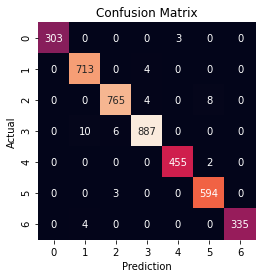

In [49]:
mat = confusion_matrix(y_pred, y_bridge)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

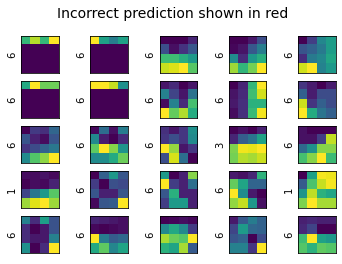

In [50]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(bridge4x4[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y_bridge[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

There's no red number popup, that mean 100% rate prediction as expected.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
X_bridge_train_np, X_bridge_test_np, y_bridge_train_np, y_bridge_test_np = train_test_split(bridge_np, y_bridge, test_size=0.3, shuffle = True, random_state=42)

In [52]:
X_bridge_train_np.shape

(2867, 16)

In [53]:
#best_model = kmeans_per_k[best_index]
best_model = KMeans(n_clusters=best_k,random_state=47)
X_train_reduced = best_model.fit_transform(X_bridge_train_np)
X_test_reduced = best_model.transform(X_bridge_test_np)
X_train_reduced.shape, X_test_reduced.shape

((2867, 7), (1229, 7))

In [54]:
cross_val_score(RF_bridge, X_train_reduced, y_bridge_train_np, cv=3, scoring='accuracy').mean()

0.9703516688938056

Fit to training model

In [55]:
RF_bridge = RandomForestClassifier(n_estimators=100,random_state=47)
RF_bridge.fit(X_train_reduced, y_bridge_train_np)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=47, verbose=0,
                       warm_start=False)

Test the model using testing set

In [56]:
bridge_score_kmean_reduction=RF_bridge.score(X_test_reduced, y_bridge_test_np)
bridge_score_kmean_reduction

0.9715215622457283

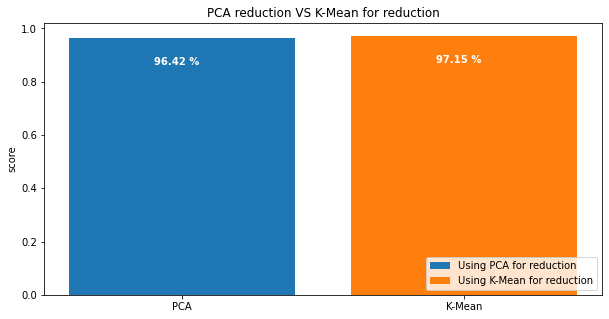

In [57]:
plt.figure(figsize=(10,5))
plt.bar(1,bridge_score_pca,label='Using PCA for reduction')
plt.bar(2,bridge_score_kmean_reduction,label='Using K-Mean for reduction')
plt.xticks([1,2],['PCA','K-Mean'])
plt.text(0.9,bridge_score_pca-0.1,'{:.2f} %'.format(bridge_score_pca*100),color="white", weight='bold')
plt.text(1.9,bridge_score_kmean_reduction-0.1,'{:.2f} %'.format(bridge_score_kmean_reduction*100),color="white", weight='bold')
plt.legend(loc='lower right')
plt.ylabel('score')
plt.title('PCA reduction VS K-Mean for reduction')
plt.show()

## Search for the number of clusters that provides the best performance.

In [58]:
from sklearn.pipeline import Pipeline

pipe_bridge_scores = []
for n_clusters in range(1,11):
    pipe_bridge = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe_bridge.fit(X_bridge_train, y_bridge_train)

    pipe_bridge_scores.append([])
    pipe_bridge_scores[n_clusters-1].append(n_clusters)
    score = pipe_bridge.score(X_bridge_test, y_bridge_test)
    pipe_bridge_scores[n_clusters-1].append(score)


    print(n_clusters, score)

1 0.46541903986981287
2 0.9471114727420668
3 0.9446704637917006
4 0.9487388120423108
5 0.9495524816924329
6 0.951993490642799
7 0.9731489015459723
8 0.9747762408462164
9 0.9764035801464606
10 0.9739625711960944


### n_clusters >= 7 provides classifier similart highest performance.

In [0]:
#Convert the list to a DataFrame to get each column separately
pipe_bridge_scores_df = pd.DataFrame(pipe_bridge_scores,columns=['n_cluster','score'])
pipe_bridge_n_clusters = pipe_bridge_scores_df['n_cluster']
pipe_bridge_scores_only = pipe_bridge_scores_df['score']

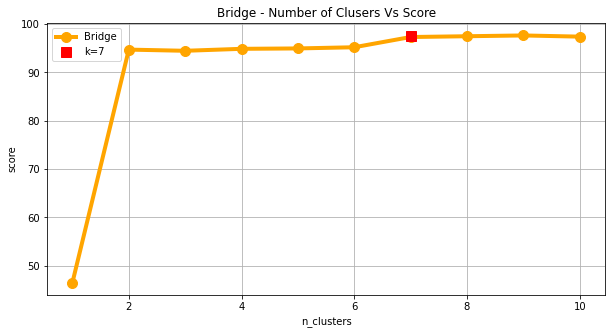

In [60]:
#Plot the chart
linewidth= 4.0
markersize=10.0
plt.figure(figsize=(10,5))
plt.plot(pipe_bridge_n_clusters,pipe_bridge_scores_only*100,'bo-',label='Bridge',color='orange',linewidth=linewidth, markersize=markersize)
plt.plot(7,pipe_bridge_scores[7][1]*100,'rs',markersize=markersize,label='k={}'.format(best_k))
plt.xlabel('n_clusters')
plt.ylabel('score')
plt.title('Bridge - Number of Clusers Vs Score')
plt.legend()
plt.grid(True)
plt.show()

##With Gaussian Mixtures

Plot AIC and BIC as a function as the number of GMM to find the best components

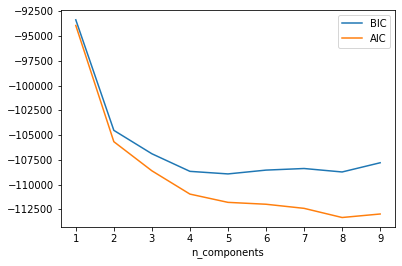

In [61]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_bridge_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_bridge_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_bridge_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Choose n_component = 7

Train the GaussianMixture model on the training set with PCA(99% variation)

In [62]:
gm = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm.fit(X_bridge_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [63]:
gm.converged_

True

How many iterations did it take?

In [64]:
gm.n_iter_

46

You can now use the model to predict which cluster each instance belongs to (hard clustering).

In [65]:
gm.predict(X_bridge_test)

array([0, 0, 0, ..., 1, 4, 2])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [66]:
gm2d = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm2d.fit(X_bridge_2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

## Anomaly Detection using Gaussian Mixtures

In [0]:
densities = gm.score_samples(X_bridge_train)
density_threshold = np.percentile(densities, 5) #Choose 5% for threshold
anomalies = X_bridge_train[densities < density_threshold]

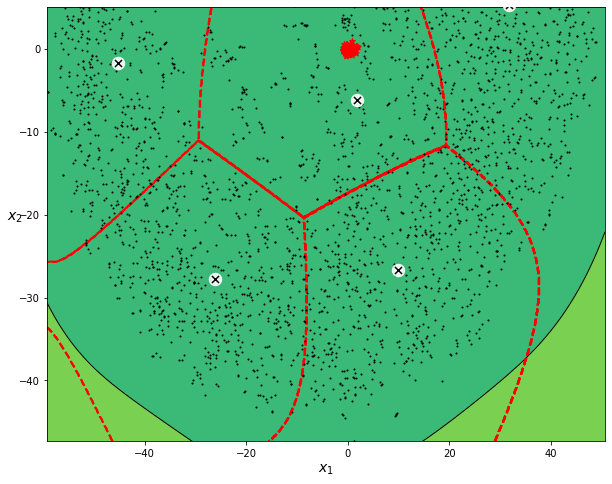

In [68]:
plt.figure(figsize=(10, 8))
plot_gaussian_mixture(gm2d, X_bridge_2d)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

# Clustering Coil-100 Image Dataset

##Data Scrubing

## Loading Data

Download Coil100 from Sean Kaggle

In [0]:
root_path = 'data'
if not os.path.exists(root_path):
  os.mkdir(root_path)

In [70]:
download('https://storage.googleapis.com/kaggle-data-sets/589973/1063434/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586807344&Signature=nbczSB2o%2FNvIWKAU8Ev%2FIVwe%2FUU0edxsPQd1XI%2BFjhkLm8TkqEPdO2yN0F7P8C7Vk81k247LhlzimGCzVo3xW2IxcfFGrp1H5kaCWWrz%2FzVHcIA1A2z9Pw3vpjmrCGTDy2vo5jh1J71WPJaM0EVwzhc8re91xYGQmJl2kc%2F31b9mjrjLo73eLKYP3JLpTbfCi1SoFOjhoIHNAyKBcKmL%2Bc8PMTfTMTwSNQTrR%2F9ncXkGUrKWMYFm250xhLWHpaVz2QS8%2B4X%2FLDv%2BxYwf73klUeEzo3acOP736YU5Up9FB%2F4uBlLBapkyVPrPcA1tHfoDwXr2BMVxf2WbWNnaS%2F999w%3D%3D&response-content-disposition=attachment%3B+filename%3Dcoil100.zip',os.path.join(root_path,'coil100'),'coil100.zip')

file is being downloading from https://storage.googleapis.com/kaggle-data-sets/589973/1063434/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586807344&Signature=nbczSB2o%2FNvIWKAU8Ev%2FIVwe%2FUU0edxsPQd1XI%2BFjhkLm8TkqEPdO2yN0F7P8C7Vk81k247LhlzimGCzVo3xW2IxcfFGrp1H5kaCWWrz%2FzVHcIA1A2z9Pw3vpjmrCGTDy2vo5jh1J71WPJaM0EVwzhc8re91xYGQmJl2kc%2F31b9mjrjLo73eLKYP3JLpTbfCi1SoFOjhoIHNAyKBcKmL%2Bc8PMTfTMTwSNQTrR%2F9ncXkGUrKWMYFm250xhLWHpaVz2QS8%2B4X%2FLDv%2BxYwf73klUeEzo3acOP736YU5Up9FB%2F4uBlLBapkyVPrPcA1tHfoDwXr2BMVxf2WbWNnaS%2F999w%3D%3D&response-content-disposition=attachment%3B+filename%3Dcoil100.zip ...
Done, file in the path data/coil100/coil100.zip


In [71]:
extractZip('data/coil100/coil100.zip', 'data/coil100/imgs')

Extracting is starting....
Done


In [0]:
coil_100_lst = os.listdir('data/coil100/imgs/coil-100')

In [73]:
len(coil_100_lst)

7202

before deleteing none-image files the number of files are 7202 

In [74]:
# Remove files that are not image
for item in coil_100_lst:
    if not item.lower().endswith('.png'):
      path = os.path.join('data/coil100/imgs/coil-100', item)
      os.remove(path)
      print('Successfully deleted the file: {}'.format(path))

Successfully deleted the file: data/coil100/imgs/coil-100/convertGroupppm2png.pl
Successfully deleted the file: data/coil100/imgs/coil-100/convertGroupppm2png.pl~


after deleting the non-image files with total 2 files.

In [75]:
coil_100_lst = os.listdir('data/coil100/imgs/coil-100')
len(coil_100_lst)

7200

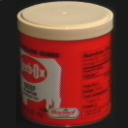

image size (128, 128, 3) 


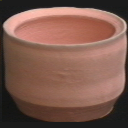

image size (128, 128, 3) 


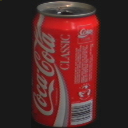

image size (128, 128, 3) 


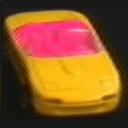

image size (128, 128, 3) 


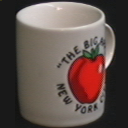

image size (128, 128, 3) 


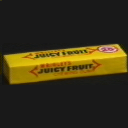

image size (128, 128, 3) 


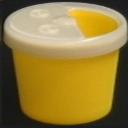

image size (128, 128, 3) 


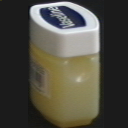

image size (128, 128, 3) 


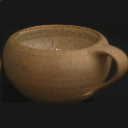

image size (128, 128, 3) 


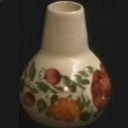

image size (128, 128, 3) 


In [76]:
# Plot to see some images of the dataset
for i in range(10):
  rndIndx = random.randint(0,len(coil_100_lst)-1)
  img = cv2.imread(os.path.join('data/coil100/imgs/coil-100',coil_100_lst[rndIndx]))
  cv2_imshow(img)
  print('image size {} '.format(img.shape))


###Create the images dataset

In [0]:
coil_100=create_img_set(os.path.join('data/coil100/imgs/coil-100'))

Show randomly 25 images from the training set

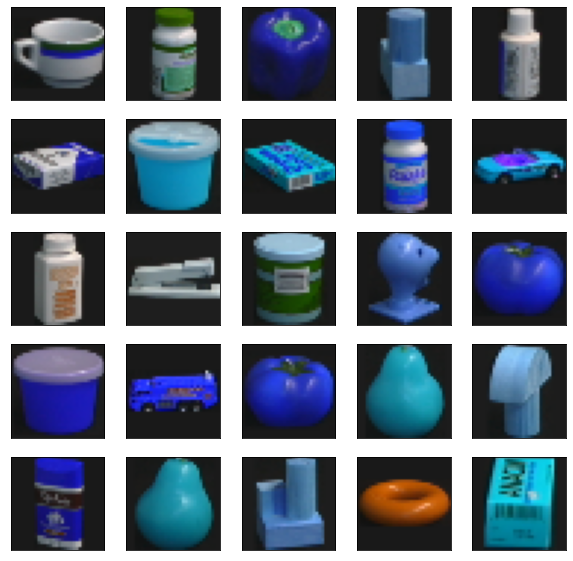

In [78]:
randomly_show_imgs(coil_100,5,5)

###Flatten the set

convert first the coil_100 from list to numpy array

In [0]:
coil_100_npa = np.array(coil_100)

In [80]:
coil_100_npa.shape

(7200, 32, 32, 3)

Get a subset of size 5000 to speed up the execution of code

In [81]:
coil_100_npa=getRandomSubset(coil_100_npa,1000)

subset (1000, 32, 32, 3)


Flatten the data

In [0]:
nsamples, nx, ny, nz = coil_100_npa.shape
coil_100_npa = coil_100_npa.reshape((nsamples,nx*ny*nz))

In [83]:
coil_100_npa.shape

(1000, 3072)

Scale the dataset

In [0]:
coil_100_npa = coil_100_npa/255

In [85]:
coil_100_npa

array([[0.09803922, 0.09803922, 0.09803922, ..., 0.09803922, 0.09803922,
        0.09803922],
       [0.09803922, 0.09803922, 0.09803922, ..., 0.09803922, 0.09803922,
        0.09803922],
       [0.09803922, 0.09803922, 0.09803922, ..., 0.09803922, 0.09803922,
        0.09803922],
       ...,
       [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392, 0.10980392,
        0.10980392],
       [0.09803922, 0.09803922, 0.09803922, ..., 0.09803922, 0.09803922,
        0.09803922],
       [0.10980392, 0.10980392, 0.10980392, ..., 0.10980392, 0.10980392,
        0.10980392]])

###Plot the dataset

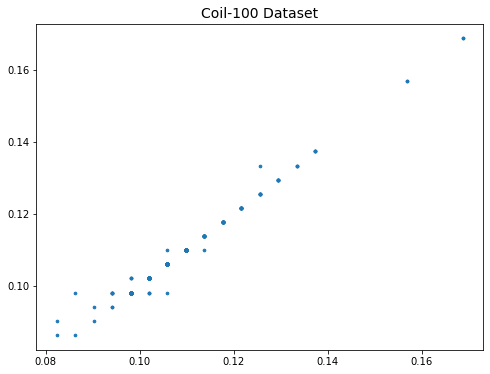

In [86]:
plt.figure(figsize=(8,6))
plt.scatter(coil_100_npa[:,0],coil_100_npa[:,1],s=7)
plt.title('Coil-100 Dataset',fontsize =14)
plt.show()

### Apply PCA (Variation = 99%)

In [87]:
pca = PCA(0.99)
X_coil100_pca = pca.fit_transform(coil_100_npa)
pca.n_components_

438

##K-means clustering

Choose random numbers of $k$ to find the best one

In [88]:
k_range = range(5,150,5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_coil100_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


### Plot the silhouette score vs performance of $k$

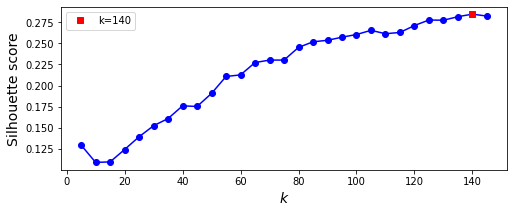

In [89]:
silhouette_scores = [silhouette_score(X_coil100_pca, model.labels_) for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs",label='k={}'.format(best_k))
plt.legend()
plt.show()

###$k$=140 return the highest Sihouette score

In [90]:
best_k

140

##Plot K-Elbow

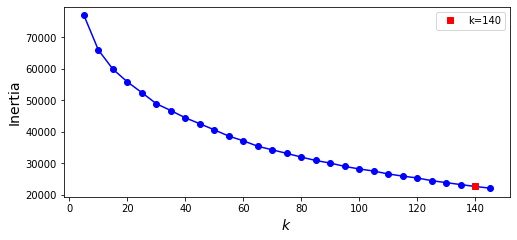

In [91]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs",label='k={}'.format(best_k))
plt.legend()
plt.show()

Actually the elbow point is k=140

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=best_k, random_state=42)

In [0]:
y_coil100 = kmodel.fit_predict(X_coil100_pca)

In [94]:
y_coil100

array([120, 100,  51,  55,  63,  37,  46,  89,  57, 105,  16, 110, 100,
        61,  33,  61,  62,  74,  62,  47,  57,  73,  73,  62, 112,  75,
        16,  66,  85,  11,   1,  69, 116,  35,  62, 107,  51,  84,  16,
       119,  52,  74,   6,  58,  24,  81,  15,  21,  22,   7,  61,  97,
        84, 123, 105,   9, 103,  72,  79,  63,  43,  39,  12,  24,  13,
        75,  24,  32,  35,  38,  30, 109, 124,  24,  92, 131,  39,  37,
        85,  32,  55,  43,  13,   5,  53,  60, 122,   3,  25,  38, 112,
        46,  96,  97,  75,  94,  74, 127,  77,  89,  10,  84,  79,  69,
        61,  34, 138,  23, 124,  15,  11,   1,   6,  18, 118,  52,  14,
        35,  18, 136, 117, 117,  96,  14,  20,   1,  91,  15,  96,  79,
        95,   5,  28,  75,  32,  10,   4, 102,  91, 105,   1,   8,  62,
        62,  60,   9,  60,  82, 132,  13,  11,  40,  32,  25, 111, 136,
        96,  42,  79, 136,  54,  30, 102,   4,  11,  59,  37,  68,  20,
       122, 138,   4, 133,   4,  15,  29,  51,   4,  48,  40,  9

In [95]:
np.unique(y_coil100)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139], dtype=int32)

In [96]:
y_coil100 is kmodel.labels_

True

Therefore, y is the label (0, 1,..,139) tha represents for each cluster.

###Plot K-means clusters

In [0]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=best_k, rseed=0, ax=None):

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=y_coil100, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[y_coil100 == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

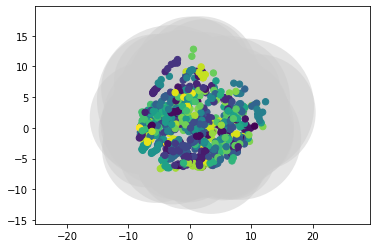

In [98]:
plot_kmeans(kmodel, X_coil100_pca)

In [0]:
coil_100_2d = reduceTo2D(coil_100_npa)

In [100]:
coil_100_2d.shape

(1000, 2)

In [101]:
kmodel2d = KMeans(n_clusters=best_k, random_state=42)
kmodel2d.fit(coil_100_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=140, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

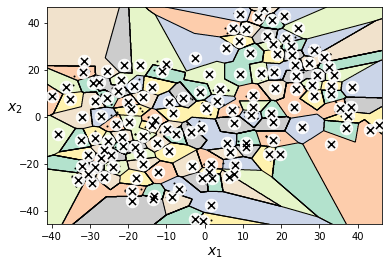

In [102]:
plot_decision_boundaries(kmodel2d,coil_100_2d)

##With RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_coil100_train, X_coil100_test, y_coil100_train, y_coil100_test = train_test_split(X_coil100_pca, y_coil100, test_size=0.3, shuffle = True, random_state=42)

In [104]:
X_coil100_train.shape, X_coil100_test.shape, y_coil100_train.shape, y_coil100_test.shape

((700, 438), (300, 438), (700,), (300,))

Create the model and fit with the training set

In [105]:
from sklearn.ensemble import RandomForestClassifier

RF_coil100 = RandomForestClassifier(random_state=42)
RF_coil100.fit(X_coil100_train, y_coil100_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [106]:
cross_val_score(RF_coil100, X_coil100_pca, y_coil100, cv=3, scoring='accuracy').mean()

0.759969550388712

Test the model using testing set

In [107]:
coil100_score_pca=RF_coil100.score(X_coil100_test, y_coil100_test)
coil100_score_pca

0.7666666666666667

See the predict score

In [108]:
y_pred = RF_coil100.predict(X_coil100_pca)
y_pred

array([120, 100,  51,  55,  63,  41,  46,  89,  57,  34,  16, 110, 100,
        61,  33,  61,  62,  74,  62,  47,  57,  73,  73,  62, 112,  75,
        16,  66,  85,  11,   1,  69, 116,  35,  62, 107,  51,  84,  16,
       119,  52,  74,   6,  58,  24,  81,  15,  21,  22,   7,  61,  97,
        84, 123, 105,   9, 103,  72,  79,  74,  96,  39,  12,  24,  13,
        75,  24,  32,  35,  38,  30, 109, 124,  24,  92, 131,  39,  37,
        85,  32,  55,  43,  13,   5,  10,  60,  62,   3,  25,  38, 112,
        46,  96,  97,  75,  94,  74,   9,  77,  89,  10,  96,  79,  69,
        61,  34, 138,  23, 124,  15,  11,   1,   6,  18, 118,  52,  14,
        35,  18, 136, 117, 117,  96,  14,  20,   1,  91,  15,  96,  79,
        95,   5,  28,  75,  32,  10,   4, 102,  91, 105,   1,  74,  62,
        62,  60,   9,  60,  82, 132,  13,  11,  40,  32,  25, 111,  62,
        96,  42,  79, 136,  54,  30, 102,   4,  11,  59,  37,  68,  20,
       122, 138,   4, 133,   4,  15,  29,  51,   4,  48,  40,  9

In [109]:
accuracy_score(y_coil100, y_pred)

0.93

See the confustion matrix

In [0]:
labels= np.unique(kmodel.labels_)

185 With 200 labels, the table would be too nasty to read.

Text(0.5, 1.0, 'Confusion Matrix')

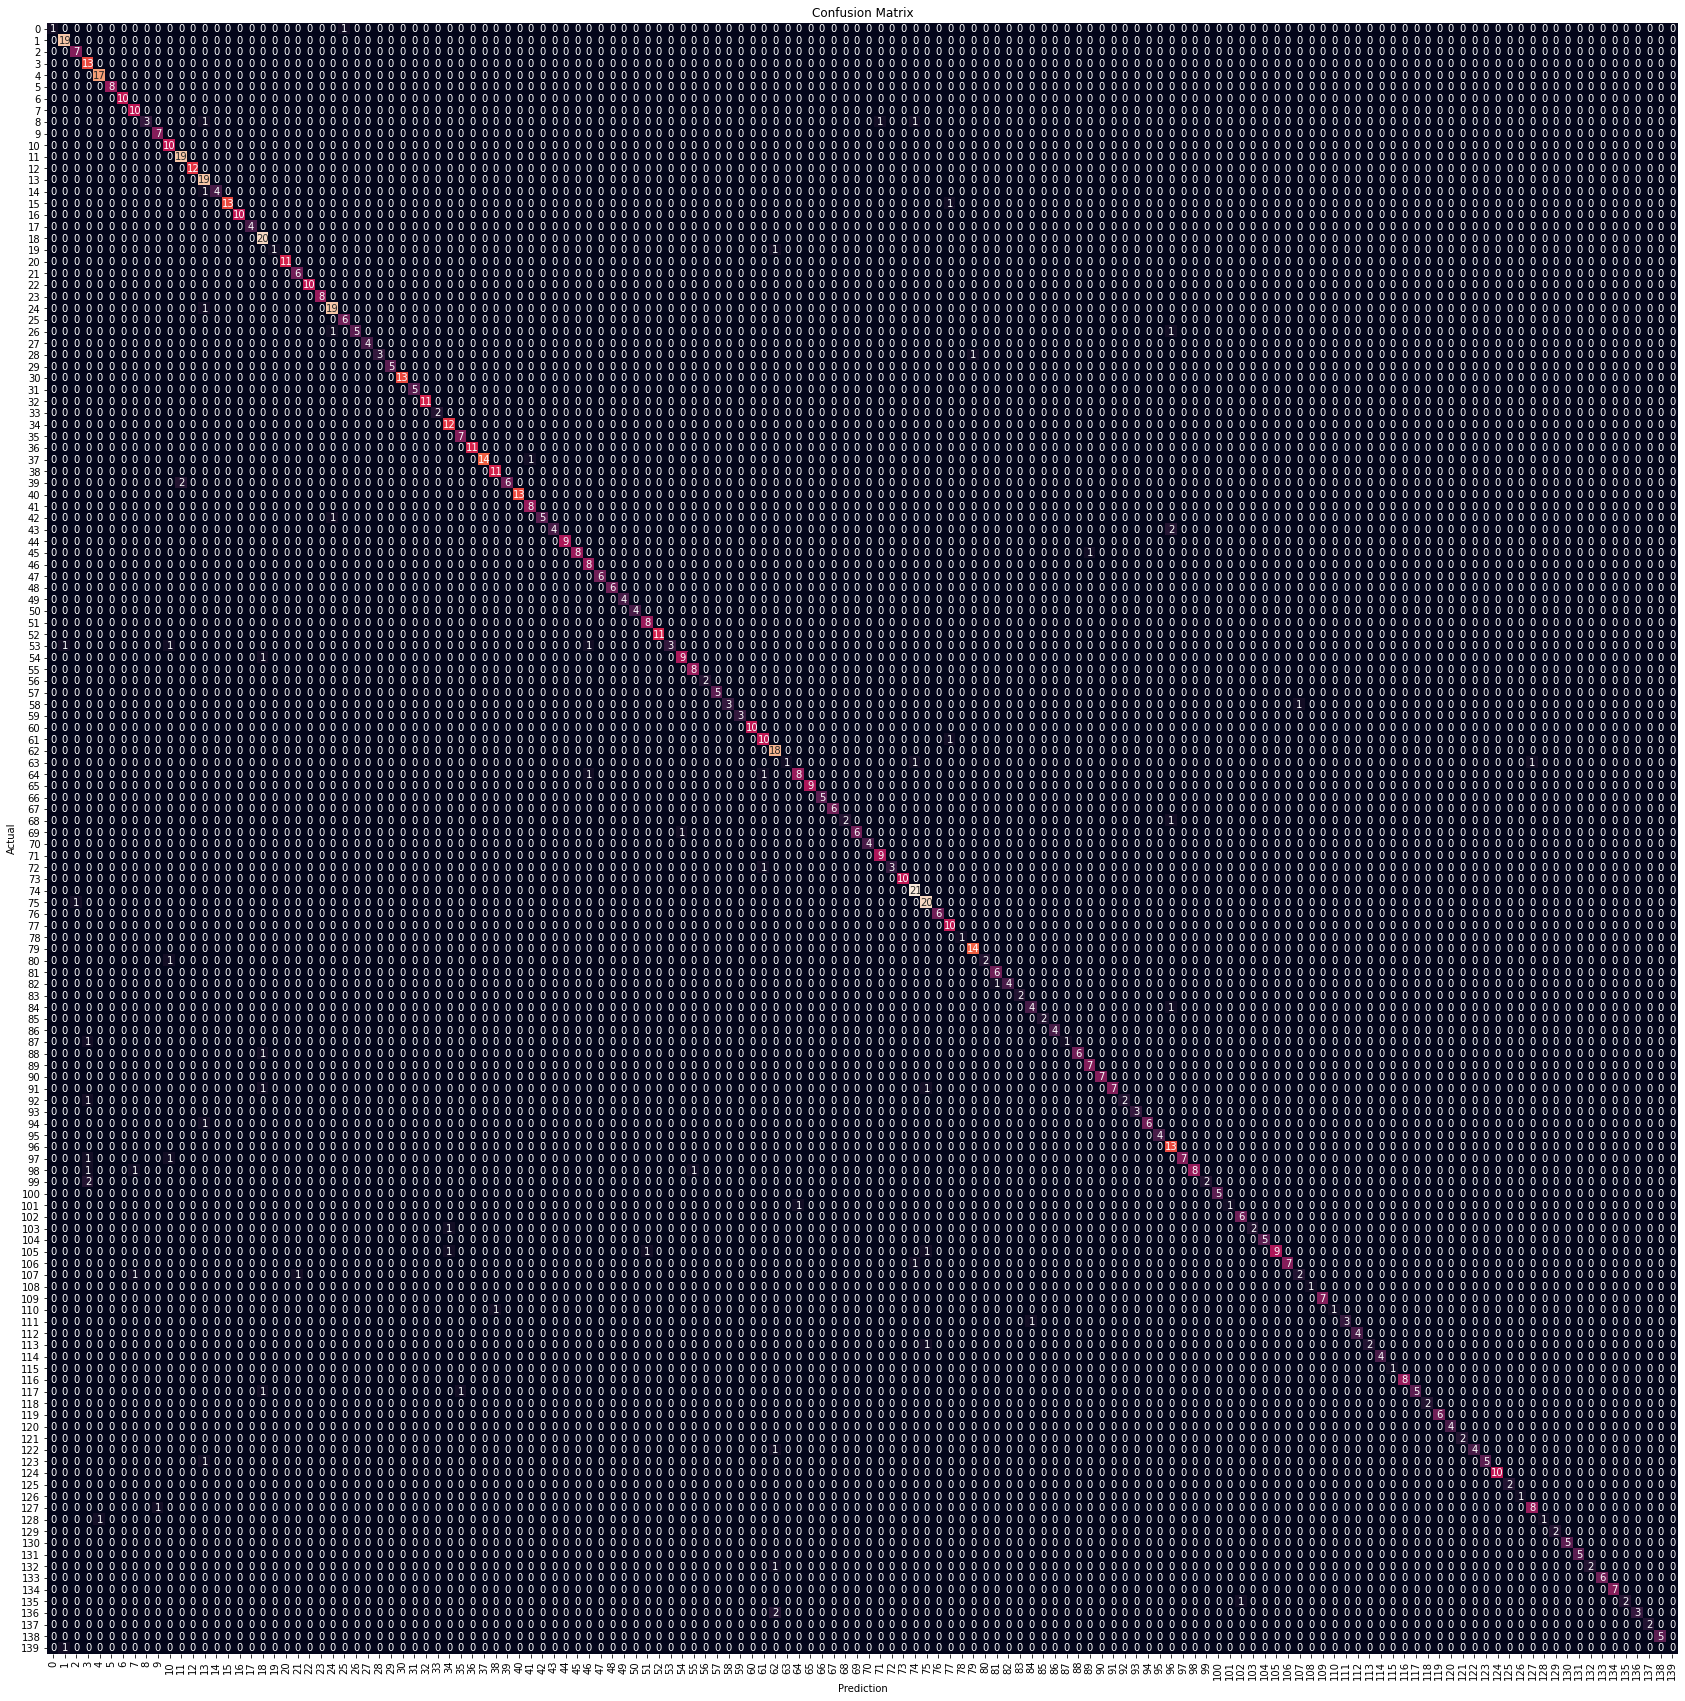

In [111]:
fig, ax = plt.subplots(figsize=(30,30)) 
mat = confusion_matrix(y_pred, y_coil100)
sns.heatmap(mat.T, square=True, annot=True,fmt='d',
            cbar=False, ax=ax,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

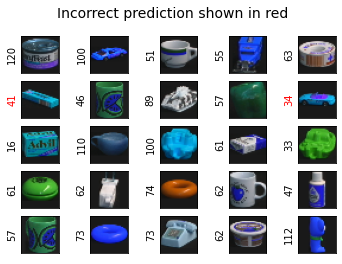

In [112]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(coil_100[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y_coil100[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

There are two error in classificaiton

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
X_coil100_train_np, X_coil100_test_np, y_coil100_train_np, y_coil100_test_np = train_test_split(coil_100_npa, y_coil100, test_size=0.3, shuffle = True, random_state=42)

In [114]:
best_model = KMeans(n_clusters=best_k, random_state=42)
X_train_coil100_reduced = best_model.fit_transform(X_coil100_train_np)
X_test_coil100_reduced = best_model.transform(X_coil100_test_np)
X_train_coil100_reduced.shape, X_test_coil100_reduced.shape

((700, 140), (300, 140))

In [115]:
cross_val_score(RF_coil100, X_train_coil100_reduced, y_coil100_train_np, cv=3, scoring='accuracy').mean()

0.827146228433782

Fit to training model

In [116]:
RF_coil100.fit(X_train_coil100_reduced, y_coil100_train_np)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [117]:
coil100_score_kmean_reduction=RF_coil100.score(X_test_coil100_reduced, y_coil100_test_np)
coil100_score_kmean_reduction

0.85

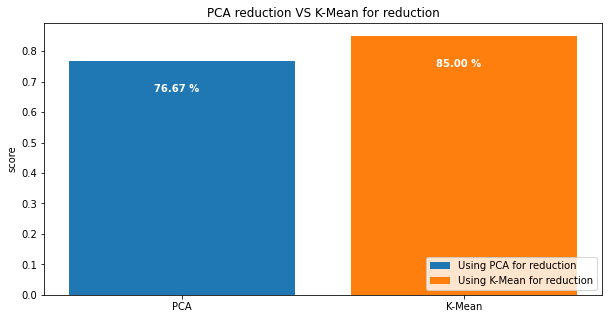

In [118]:
plt.figure(figsize=(10,5))
plt.bar(1,coil100_score_pca,label='Using PCA for reduction')
plt.bar(2,coil100_score_kmean_reduction,label='Using K-Mean for reduction')
plt.xticks([1,2],['PCA','K-Mean'])
plt.text(0.9,coil100_score_pca-0.1,'{:.2f} %'.format(coil100_score_pca*100),color="white", weight='bold')
plt.text(1.9,coil100_score_kmean_reduction-0.1,'{:.2f} %'.format(coil100_score_kmean_reduction*100),color="white", weight='bold')
plt.legend(loc='lower right')
plt.ylabel('score')
plt.title('PCA reduction VS K-Mean for reduction')
plt.show()

The performance produce slighly higher error than when using PCA. 

## Search for the number of clusters that provides the best performance.

In [119]:
from sklearn.pipeline import Pipeline

pipe_coil100_scores = []
indx = 0
for n_clusters in range(5,150,5):
    pipe = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe.fit(X_coil100_train, y_coil100_train)

    pipe_coil100_scores.append([])
    pipe_coil100_scores[indx].append(n_clusters)
    score = pipe.score(X_coil100_test, y_coil100_test)
    pipe_coil100_scores[indx].append(score)
    indx = indx + 1
    
    print(n_clusters, score)

5 0.7233333333333334
10 0.7733333333333333
15 0.8
20 0.81
25 0.7933333333333333
30 0.81
35 0.81
40 0.81
45 0.8233333333333334
50 0.82
55 0.82
60 0.83
65 0.8333333333333334
70 0.8466666666666667
75 0.8333333333333334
80 0.8266666666666667
85 0.83
90 0.8433333333333334
95 0.85
100 0.8433333333333334
105 0.8466666666666667
110 0.8433333333333334
115 0.8433333333333334
120 0.8466666666666667
125 0.8466666666666667
130 0.8433333333333334
135 0.8433333333333334
140 0.8433333333333334
145 0.8466666666666667


In [0]:
pipe_coil100_scores_df = pd.DataFrame(pipe_coil100_scores,columns=['n_cluster','score'])
pipe_coil100_n_clusters = pipe_coil100_scores_df['n_cluster']
pipe_coil100_scores_only = pipe_coil100_scores_df['score']

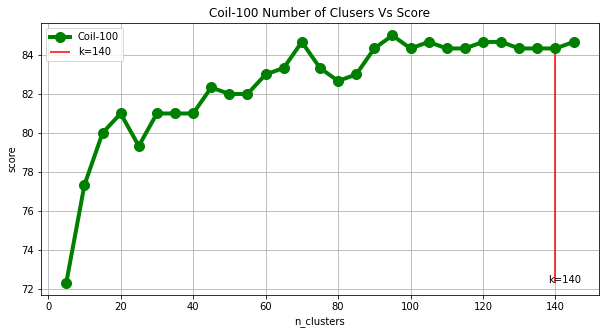

In [121]:
#Plot the chart
linewidth= 4.0
markersize=10.0
plt.figure(figsize=(10,5))
plt.plot(pipe_coil100_n_clusters,pipe_coil100_scores_only*100,'bo-',label='Coil-100',color='green',linewidth=linewidth, markersize=markersize)
plt.vlines(best_k,np.min(pipe_coil100_scores_only)*100,
           pipe_coil100_scores_only[pipe_coil100_scores_df.n_cluster[pipe_coil100_scores_df.n_cluster == best_k].index]*100,
           label='k={}'.format(best_k),color='red')
plt.text(best_k-2,np.min(pipe_coil100_scores_only)*100,'k={}'.format(best_k))
plt.xlabel('n_clusters')
plt.ylabel('score')
plt.title('Coil-100 Number of Clusers Vs Score')

plt.legend()
plt.grid(True)
plt.show()

##With Gaussian Mixtures

Plot AIC and BIC as a function as the number of GM to find the best components

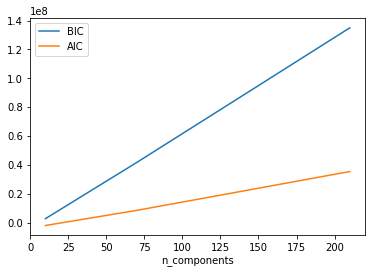

In [122]:
from sklearn.mixture import GaussianMixture

n_components = [10,70,140,210]
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_coil100_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_coil100_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_coil100_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

So, n_component = 140 would minimize both BIC and AIC.

Train a Gaussian mixture model on the training set

In [123]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm.fit(X_coil100_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=140, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [124]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [125]:
gm.n_iter_

2

You can now use the model to predict which cluster each instance belongs to (hard clustering).

In [126]:
gm.predict(X_coil100_test)

array([115,   5,  59,  39,  91,  86,  36, 118,  14,   7,  14, 118,  28,
         2,  10,  23,  46, 111,   1,  79,  58,  21, 107,  56, 108,  53,
        74,  28,  46,  86,  31, 118,  25,   7, 102,  49,  39, 100,  25,
        79,  27,  85,  10,  16,  16, 104,   2,  94,  29,   7,  16,  21,
       108,  68,   4,   2, 120,  19,  57,   7, 109,  27,  14,  91,   2,
        65,  27,  65,  53,   8,  34,  64,   9,  14,  38,  92,  57,  67,
        78, 126,  46,  46,  82,  13,  45,  37,  60,  10,  76, 119,  41,
       116,  27,  46,  10,  39,   4,  88,  46,  81,  85,  52,  95,  49,
        94,  59,  46,  71,  82,  72,  39,  82,  46,   5,  36, 122,   9,
        48, 125, 109,   4,  79,  86,  44, 107,  91,  78,  11,  96,  81,
         8,  57,  96,  45,  35,  24,  28,  27,  10,  96,  46,  75, 118,
         0,  65,  20, 110, 125, 108,  48,  68,  64,  13,  10,  10,  23,
        21, 130, 103, 118,  64,   0,   3,  67, 118,   2,  53,  39,  72,
         0,   7,  73,  27,  29,  21, 109,   9,  33,  51,   2,   

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [127]:
gm2d = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm2d.fit(coil_100_2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=140, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

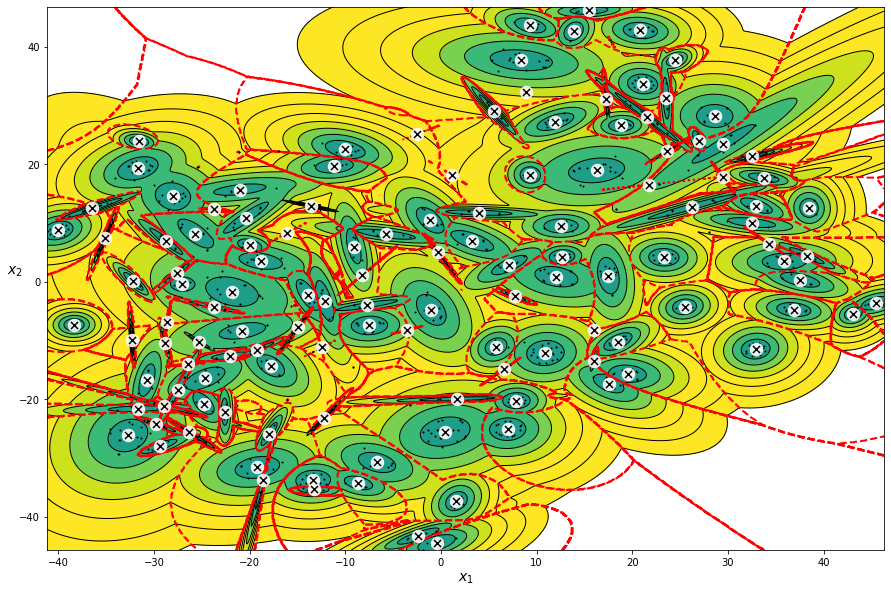

In [128]:
plt.figure(figsize=(15, 10))
plot_gaussian_mixture(gm2d, coil_100_2d)
plt.show()

## Anomaly Detection using Gaussian Mixtures

Assume the threshold is 10%

In [0]:
densities = gm2d.score_samples(coil_100_2d)
density_threshold = np.percentile(densities, 10)
anomalies = coil_100_2d[densities < density_threshold]

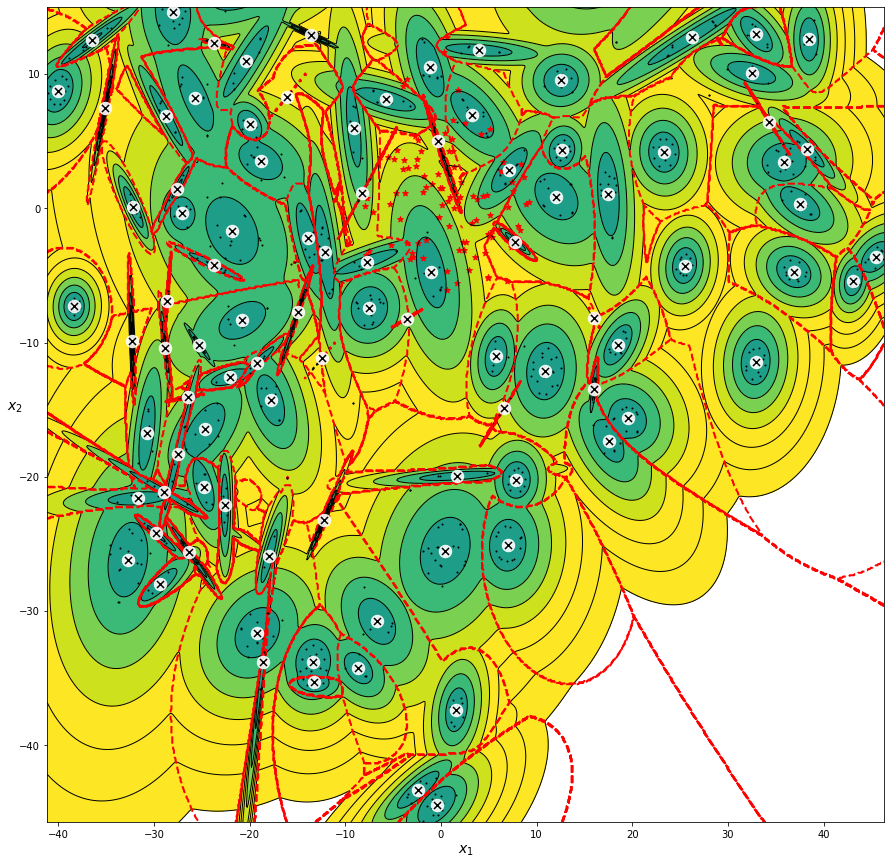

In [133]:
plt.figure(figsize=(15, 15))

plot_gaussian_mixture(gm2d, coil_100_2d)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=15)
plt.show()

#Clustering Celeba Dataset

##Loading Downsampled Dataset

here, the celeba data will be downloaded to the path 'data/celeba'



In [137]:
url = 'https://storage.googleapis.com/kaggle-data-sets/591568/1066047/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586864095&Signature=S7GbMgzBMqJ2GGwgady%2Bu8EqjrTagXnimeUdpBs8Mwj71UGOwqkr0lclMaC2NqhAJDl8s7Cdc%2F8wUn1fW9u%2BiFryJLX2U80Ada1jHubvKe2tRxf1DOu%2FEQIDn31swxosjP2z8QIvLK7baTd2K9mQcBRdKyo4A%2Fx%2BlLrRQ%2ByOKzG%2Bta4YlNdNHA0xjX7LfboWkRAYvetgkOXdmeHZsKk0dKePMTBTOUbuI87ToEOdtUbFSbZ11A%2FNreu1hH5eHNorqn10OpTfNDhNj8mAli0rS0XHWqHtxNQc786OyL3SepCYvSy8UQq0%2BNV%2FJyZqGEB%2BllRcVgBt59rTldjyzi12jw%3D%3D&response-content-disposition=attachment%3B+filename%3Dceleba.zip'
save_path = celeba_path
download(url,save_path=save_path,target_file_name='celeba.zip')

file is being downloading from https://storage.googleapis.com/kaggle-data-sets/591568/1066047/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586864095&Signature=S7GbMgzBMqJ2GGwgady%2Bu8EqjrTagXnimeUdpBs8Mwj71UGOwqkr0lclMaC2NqhAJDl8s7Cdc%2F8wUn1fW9u%2BiFryJLX2U80Ada1jHubvKe2tRxf1DOu%2FEQIDn31swxosjP2z8QIvLK7baTd2K9mQcBRdKyo4A%2Fx%2BlLrRQ%2ByOKzG%2Bta4YlNdNHA0xjX7LfboWkRAYvetgkOXdmeHZsKk0dKePMTBTOUbuI87ToEOdtUbFSbZ11A%2FNreu1hH5eHNorqn10OpTfNDhNj8mAli0rS0XHWqHtxNQc786OyL3SepCYvSy8UQq0%2BNV%2FJyZqGEB%2BllRcVgBt59rTldjyzi12jw%3D%3D&response-content-disposition=attachment%3B+filename%3Dceleba.zip ...
Done, file in the path data/celeba/celeba.zip


Extract the celeba  dataset to the path data/celeba/imgs/

In [138]:
extractZip(os.path.join(celeba_path,'celeba.zip'),os.path.join(celeba_path,'imgs'))

Extracting is starting....
Done


##Exploring Data 

list randomly 10 images of the training data

In [139]:
main_path = os.path.join(celeba_path,'imgs/img_align_celeba')

clb_lst=os.listdir(main_path)
len(clb_lst)

202599

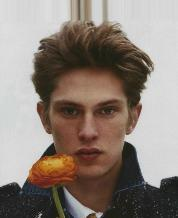

image size (218, 178, 3) 


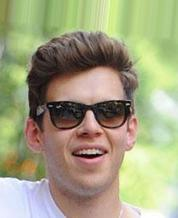

image size (218, 178, 3) 


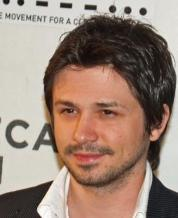

image size (218, 178, 3) 


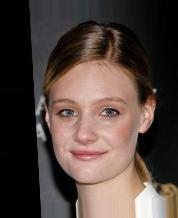

image size (218, 178, 3) 


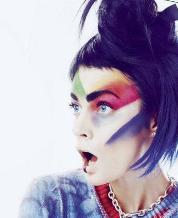

image size (218, 178, 3) 


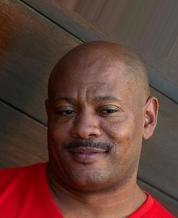

image size (218, 178, 3) 


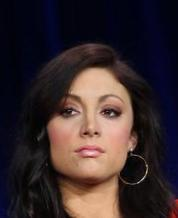

image size (218, 178, 3) 


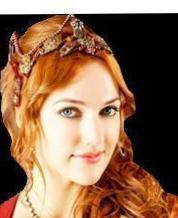

image size (218, 178, 3) 


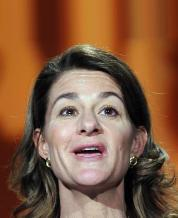

image size (218, 178, 3) 


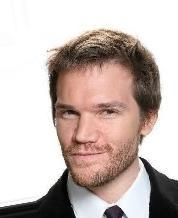

image size (218, 178, 3) 


In [140]:
for i in range(10):
  rndIndx=random.randint(0,len(clb_lst)-1)
  imgPath = os.path.join(main_path,clb_lst[rndIndx])
  img=cv2.imread(imgPath)
  cv2_imshow(img)
  print('image size {} '.format(img.shape))
   

##Creating Training Set

In [0]:
celeba_imgs_folder_path = os.path.join(celeba_path,'imgs/img_align_celeba')
clb_x= create_img_set(celeba_imgs_folder_path)

In [229]:
len(clb_x)

202599

Show randomly 25 images from the training set

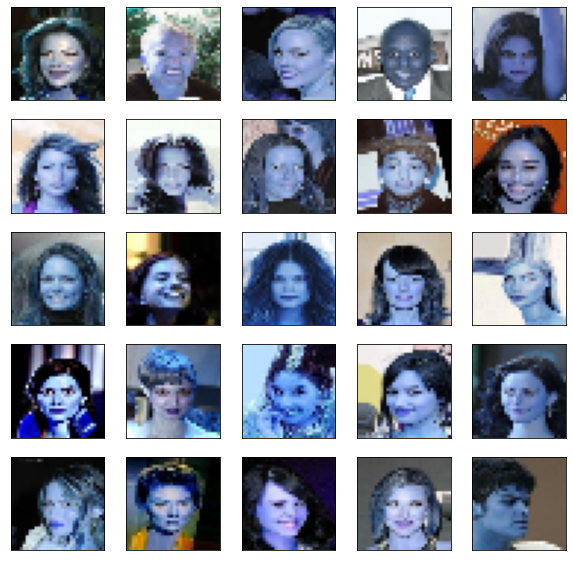

In [230]:
randomly_show_imgs(clb_x,5,5)

##Flatten the set

convert first the dsp_x from list to numpy array

In [0]:
clb_x_npa = np.array(clb_x)

In [232]:
clb_x_npa.shape

(202599, 32, 32, 3)

###For sake of experiment speed, random subset size 10000 will be used.

In [233]:
clb_x_npa= getRandomSubset(clb_x_npa,1000)

subset (1000, 32, 32, 3)


Convert the data from (202599, 32, 32, 3) to (202599, 3072) which is (202599, 32x32x3)

In [0]:
rows=int(clb_x_npa.shape[0])
cols=int(clb_x_npa.shape[1]*clb_x_npa.shape[2]*clb_x_npa.shape[3])
clb_x_npa=clb_x_npa.reshape(rows,cols)

In [235]:
clb_x_npa.shape

(1000, 3072)

Scaling data

In [236]:
clb_x_npa = clb_x_npa / 255
clb_x_npa

array([[0.07058824, 0.0745098 , 0.06666667, ..., 0.05098039, 0.05490196,
        0.04705882],
       [0.98431373, 0.9372549 , 0.94509804, ..., 0.41960784, 0.42352941,
        0.54509804],
       [0.33333333, 0.45882353, 0.41176471, ..., 0.08627451, 0.07058824,
        0.09411765],
       ...,
       [0.68235294, 0.61568627, 0.60392157, ..., 0.53333333, 0.36078431,
        0.30980392],
       [0.95294118, 0.97254902, 0.96862745, ..., 0.89803922, 0.9372549 ,
        0.91372549],
       [0.89803922, 0.5254902 , 0.        , ..., 0.09019608, 0.08235294,
        0.06666667]])

###Plot the dataset

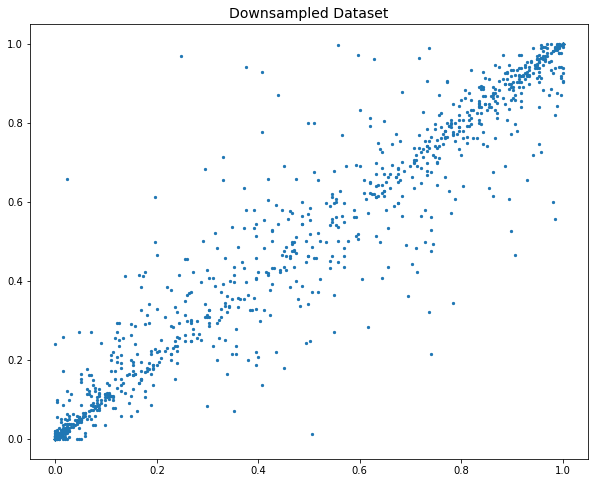

In [237]:
plt.figure(figsize=(10,8))
plt.scatter(clb_x_npa[:,0],clb_x_npa[:,1],s=5)
plt.title('Downsampled Dataset',fontsize =14)
plt.show()

### Apply PCA (Variation = 99%)

In [238]:
pca = PCA(0.99)
X_celeb_pca = pca.fit_transform(clb_x_npa)
pca.n_components_

522

##K-means clustering

Choose random numbers of $k$ to find the best one

In [239]:
k_range = range(2,40,1)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_celeb_pca)
    kmeans_per_k.append(kmeans)

k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19
k=20
k=21
k=22
k=23
k=24
k=25
k=26
k=27
k=28
k=29
k=30
k=31
k=32
k=33
k=34
k=35
k=36
k=37
k=38
k=39


### Plot the silhouette score vs performance of $k$

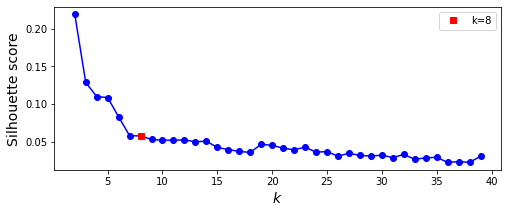

In [240]:
silhouette_scores = [silhouette_score(X_celeb_pca, model.labels_) for model in kmeans_per_k]
best_index = 6
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs",label='k={}'.format(best_k))
plt.legend()
plt.show()

###$k$ = 2 return the highest Sihouette score

In [241]:
best_k

8

##Plot K-Elbow

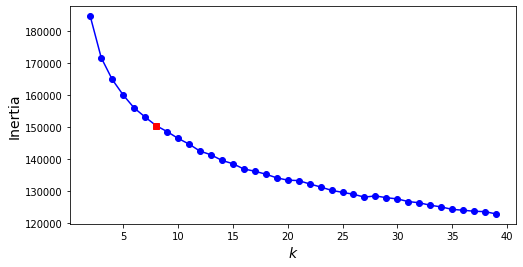

In [242]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The elbow point is $k$ = 2

###Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=best_k, random_state=42)

In [0]:
y_celeb = kmodel.fit_predict(X_celeb_pca)

In [245]:
y_celeb

array([7, 2, 1, 5, 1, 3, 7, 3, 7, 4, 1, 1, 0, 4, 7, 1, 6, 7, 7, 3, 1, 0,
       1, 2, 0, 6, 5, 4, 0, 1, 3, 4, 2, 1, 4, 3, 3, 1, 0, 0, 4, 2, 3, 6,
       0, 1, 7, 1, 2, 4, 0, 0, 5, 2, 3, 1, 6, 3, 0, 3, 5, 2, 3, 7, 6, 1,
       4, 3, 1, 7, 2, 5, 6, 7, 1, 3, 5, 7, 1, 1, 2, 6, 1, 7, 7, 0, 3, 0,
       5, 6, 4, 3, 4, 2, 3, 1, 4, 7, 2, 7, 5, 3, 3, 2, 1, 7, 3, 2, 3, 4,
       0, 4, 7, 6, 6, 0, 5, 4, 3, 4, 4, 3, 0, 2, 0, 6, 3, 6, 7, 7, 0, 2,
       3, 2, 1, 0, 3, 2, 7, 7, 1, 1, 0, 6, 6, 2, 1, 7, 7, 5, 1, 3, 7, 2,
       2, 3, 2, 1, 7, 6, 7, 6, 6, 3, 7, 0, 6, 2, 1, 2, 1, 2, 3, 1, 7, 6,
       4, 1, 7, 4, 2, 5, 1, 7, 6, 4, 4, 7, 5, 0, 7, 2, 7, 3, 2, 3, 4, 3,
       3, 7, 4, 2, 4, 1, 6, 1, 1, 4, 1, 5, 7, 6, 3, 2, 7, 7, 4, 4, 2, 5,
       1, 6, 6, 1, 3, 3, 3, 7, 1, 0, 4, 7, 1, 6, 4, 6, 6, 6, 7, 4, 1, 2,
       5, 3, 1, 4, 7, 1, 4, 4, 2, 7, 4, 7, 2, 2, 1, 4, 2, 4, 3, 7, 3, 4,
       4, 7, 4, 4, 0, 7, 7, 0, 3, 2, 2, 5, 6, 6, 4, 4, 0, 2, 0, 3, 2, 5,
       0, 3, 3, 7, 3, 0, 7, 1, 3, 1, 7, 0, 4, 3, 7,

In [246]:
y_celeb is kmodel.labels_

True

Therefore, y_pred is the label (0, 1) tha represents for each cluster.

###Plot K-means clusters

In [0]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=best_k, rseed=0, ax=None):

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=y_celeb, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[y_celeb == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

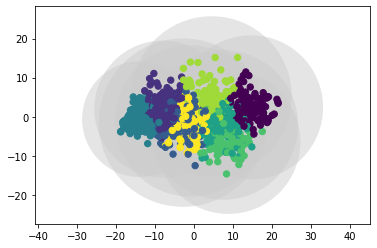

In [248]:
plot_kmeans(kmodel, X_celeb_pca)

In [249]:
celeb_2d = reduceTo2D(clb_x_npa)
celeb_2d.shape

(1000, 2)

In [250]:
kmodel2d = KMeans(n_clusters=best_k, random_state=42)
kmodel2d.fit(celeb_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

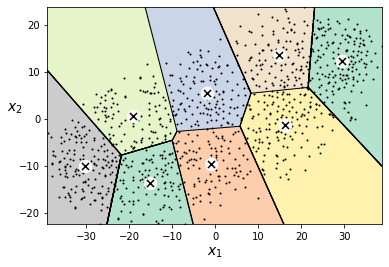

In [251]:
plot_decision_boundaries(kmodel2d,celeb_2d)

##With RandomForest Classifier



###Spliting data for training and testing set in ratio 70%-30%

In [0]:
clb_x_train, clb_x_test, clb_y_train, clb_y_test = train_test_split(X_celeb_pca, y_celeb, test_size=0.3, shuffle = True, random_state=42)

In [253]:
clb_x_train.shape, clb_y_train.shape, clb_x_test.shape, clb_y_test.shape

((700, 522), (700,), (300, 522), (300,))


Create the model and fit with the training set

In [254]:
from sklearn.ensemble import RandomForestClassifier

RF_clb = RandomForestClassifier(random_state=42)
RF_clb.fit(clb_x_train, clb_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [255]:
cross_val_score(RF_clb, X_celeb_pca, y_celeb, cv=3, scoring='accuracy').mean()

0.5439751128373883

Test the model using testing set

In [256]:
celeb_score_pca=RF_clb.score(clb_x_test, clb_y_test)
celeb_score_pca

0.5033333333333333

See the predict score

In [257]:
y_pred = RF_clb.predict(X_celeb_pca)
y_pred

array([7, 2, 1, 4, 1, 3, 7, 1, 7, 4, 3, 1, 0, 4, 7, 1, 6, 7, 7, 3, 1, 0,
       1, 4, 0, 7, 5, 4, 0, 1, 3, 4, 2, 1, 4, 3, 3, 1, 0, 0, 4, 2, 3, 6,
       7, 1, 7, 1, 2, 2, 0, 0, 5, 2, 3, 1, 6, 3, 0, 3, 7, 2, 3, 4, 6, 3,
       4, 3, 1, 7, 1, 5, 0, 7, 1, 3, 7, 4, 3, 1, 2, 1, 3, 7, 3, 0, 1, 0,
       0, 6, 4, 3, 4, 2, 3, 1, 7, 7, 2, 7, 5, 3, 3, 2, 1, 7, 3, 2, 3, 4,
       7, 4, 7, 6, 6, 0, 5, 4, 3, 4, 7, 3, 0, 2, 0, 6, 3, 6, 7, 7, 0, 2,
       3, 2, 1, 0, 3, 1, 7, 4, 1, 1, 0, 6, 6, 2, 1, 7, 7, 5, 1, 3, 7, 2,
       2, 3, 2, 1, 7, 6, 7, 6, 6, 3, 7, 4, 6, 2, 3, 2, 1, 2, 3, 1, 4, 6,
       4, 1, 7, 4, 2, 5, 1, 7, 1, 4, 4, 7, 5, 0, 7, 2, 7, 3, 2, 3, 4, 3,
       3, 0, 4, 2, 4, 1, 4, 1, 1, 4, 1, 7, 7, 4, 3, 2, 7, 7, 4, 4, 1, 5,
       1, 7, 6, 1, 3, 3, 3, 7, 1, 0, 4, 1, 1, 6, 4, 7, 6, 3, 7, 4, 1, 2,
       5, 3, 1, 4, 7, 1, 4, 4, 4, 7, 4, 7, 1, 2, 2, 4, 2, 4, 1, 7, 3, 4,
       4, 1, 1, 4, 0, 7, 7, 0, 3, 2, 2, 4, 6, 1, 4, 4, 0, 7, 0, 3, 2, 5,
       0, 3, 3, 7, 3, 0, 7, 1, 3, 1, 7, 0, 4, 3, 7,

In [258]:
accuracy_score(y_celeb, y_pred)

0.851

See the confustion matrix

In [259]:
labels= np.unique(kmodel.labels_)
labels

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

Text(0.5, 1.0, 'Confusion Matrix')

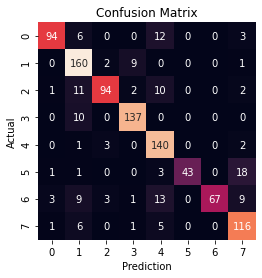

In [260]:
mat = confusion_matrix(y_pred, y_celeb)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

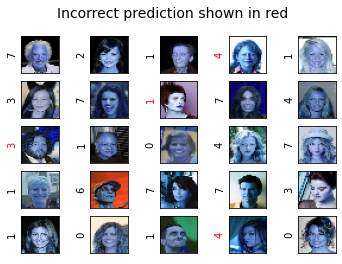

In [261]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(clb_x[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y_celeb[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

There are some miss classification

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set


In [0]:
clb_x_train_np, clb_x_test_np, clb_y_train_np, clb_y_test_np = train_test_split(clb_x_npa, y_celeb, test_size=0.3, shuffle = True, random_state=42)

In [263]:
best_model = KMeans(n_clusters=best_k, random_state=42)
X_train_reduced = best_model.fit_transform(clb_x_train_np)
X_test_reduced = best_model.transform(clb_x_test_np)
X_train_reduced.shape, X_test_reduced.shape

((700, 8), (300, 8))

In [264]:
X_train_reduced.shape,X_test_reduced.shape

((700, 8), (300, 8))

Perform cross validation using subset size 500

In [265]:
cross_val_score(RF_clb, X_train_reduced, clb_y_train_np, cv=3, scoring='accuracy').mean()

0.8542545516794444


Fit to training model

In [266]:
RF_clb.fit(X_train_reduced, clb_y_train_np)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [267]:
celeb_score_kmean_reduction = RF_clb.score(X_test_reduced, clb_y_test_np)
celeb_score_kmean_reduction

0.8333333333333334

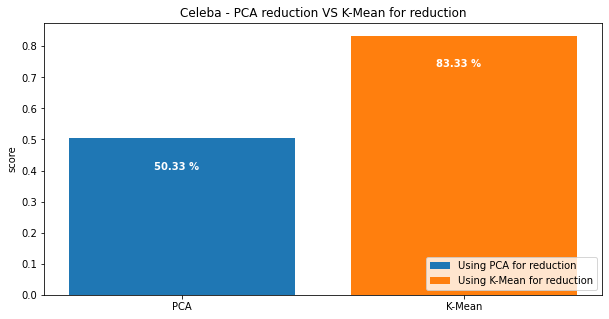

In [268]:
plt.figure(figsize=(10,5))
plt.bar(1,celeb_score_pca,label='Using PCA for reduction')
plt.bar(2,celeb_score_kmean_reduction,label='Using K-Mean for reduction')
plt.xticks([1,2],['PCA','K-Mean'])
plt.text(0.9,celeb_score_pca-0.1,'{:.2f} %'.format(celeb_score_pca*100),color="white", weight='bold')
plt.text(1.9,celeb_score_kmean_reduction-0.1,'{:.2f} %'.format(celeb_score_kmean_reduction*100),color="white", weight='bold')
plt.legend(loc='lower right')
plt.ylabel('score')
plt.title('Celeba - PCA reduction VS K-Mean for reduction')
plt.show()

There is a big improvment in using k-Mean as a reduction

##Search for the number of clusters that provides the best performance.

In [269]:
from sklearn.pipeline import Pipeline
#This list to be used for visualization
pipe_clb_scores = []
for n_clusters in range(1,20):
    pipe_clb = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    pipe_clb.fit(clb_x_train, clb_y_train)

    pipe_clb_scores.append([])
    pipe_clb_scores[n_clusters-1].append(n_clusters)
    score = pipe_clb.score(clb_x_test, clb_y_test)
    pipe_clb_scores[n_clusters-1].append(score)
    
    print(n_clusters, score)

1 0.19333333333333333
2 0.55
3 0.5266666666666666
4 0.7266666666666667
5 0.7966666666666666
6 0.8233333333333334
7 0.8133333333333334
8 0.8366666666666667
9 0.83
10 0.8166666666666667
11 0.8366666666666667
12 0.82
13 0.84
14 0.8433333333333334
15 0.83
16 0.8333333333333334
17 0.82
18 0.8433333333333334
19 0.84


So n_clusters >= 8 provides almost similar high performance.

In [0]:
pipe_clb_scores_df = pd.DataFrame(pipe_clb_scores,columns=['n_cluster','score'])
pipe_clb_n_clusters = pipe_clb_scores_df['n_cluster']
pipe_clb_scores_only = pipe_clb_scores_df['score']


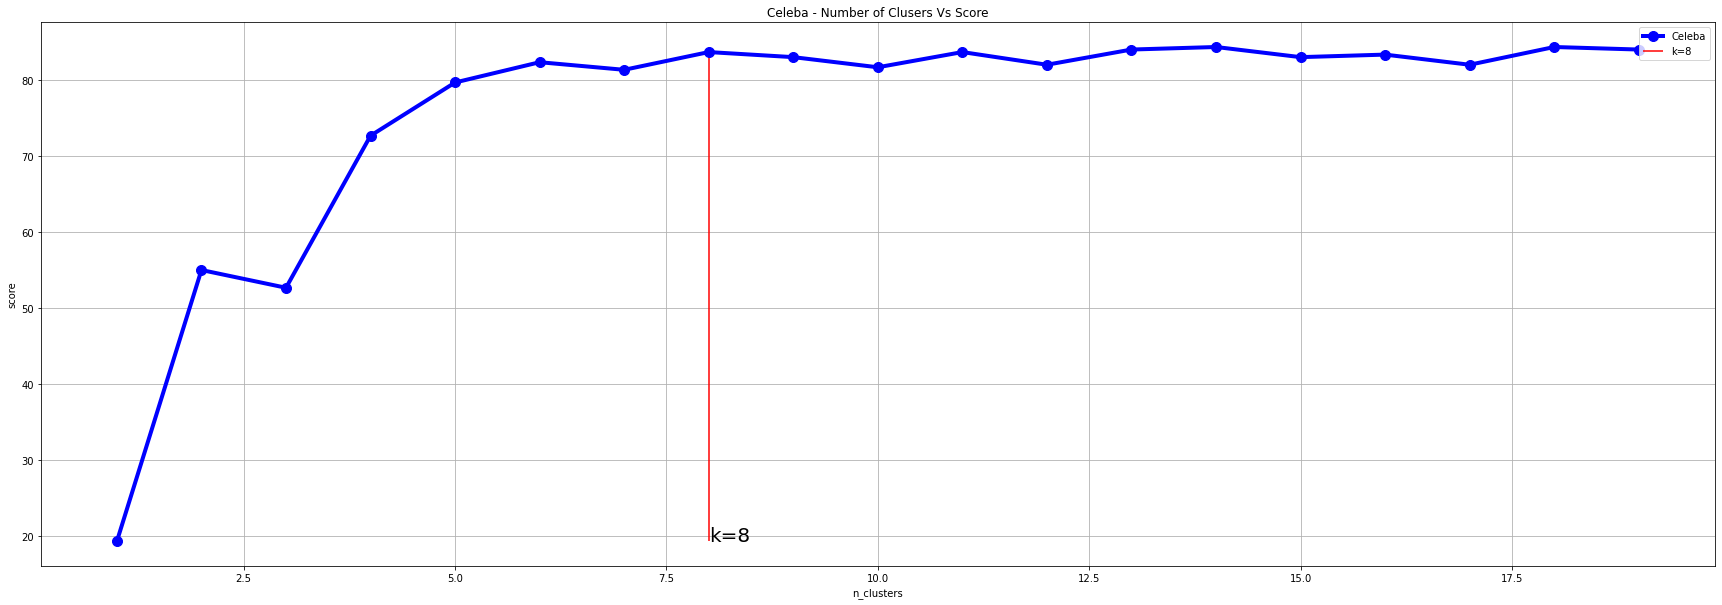

In [271]:

#Plot the chart
linewidth= 4.0
markersize=10.0
plt.figure(figsize=(30,10))
plt.plot(pipe_clb_n_clusters,pipe_clb_scores_only*100,'bo-',label='Celeba',color='blue',linewidth=linewidth, markersize=markersize)
plt.vlines(best_k,np.min(pipe_clb_scores_only)*100,
           pipe_clb_scores_only[pipe_clb_scores_df.n_cluster[pipe_clb_scores_df.n_cluster == best_k].index]*100,
           label='k={}'.format(best_k),color='red')
plt.text(best_k,np.min(pipe_clb_scores_only)*100,'k={}'.format(best_k),fontsize=20)
plt.xlabel('n_clusters')
plt.ylabel('score')
plt.title('Celeba - Number of Clusers Vs Score')
plt.legend()
plt.grid(True)
plt.show()

##With Gaussian Mixtures

Plot AIC and BIC as a function as the number of GM to find the best components

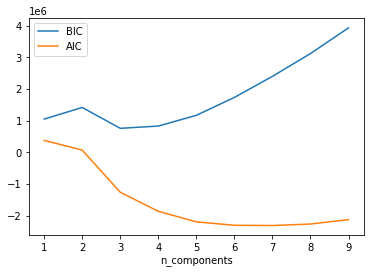

In [272]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(1,10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_celeb_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_celeb_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_celeb_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

So, n_component = 8 would minimize both BIC and AIC.

Train a Gaussian mixture model on the training set

In [273]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm.fit(clb_x_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [274]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [275]:
gm.n_iter_

2

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.

In [276]:
gm.predict(clb_x_test)

array([3, 4, 3, 2, 3, 2, 3, 1, 2, 1, 0, 3, 7, 0, 3, 1, 2, 0, 2, 1, 1, 0,
       6, 4, 4, 7, 3, 3, 1, 0, 1, 3, 2, 0, 4, 1, 3, 1, 0, 1, 0, 4, 0, 2,
       3, 0, 0, 1, 6, 6, 6, 4, 4, 0, 0, 1, 2, 0, 0, 6, 5, 3, 3, 4, 1, 2,
       0, 0, 0, 6, 0, 6, 0, 0, 4, 4, 1, 5, 0, 3, 3, 6, 2, 1, 0, 2, 2, 6,
       3, 6, 0, 1, 0, 0, 4, 1, 0, 2, 0, 2, 0, 0, 4, 0, 2, 6, 0, 4, 1, 3,
       4, 6, 2, 6, 3, 6, 0, 0, 1, 1, 2, 3, 1, 3, 5, 1, 0, 0, 0, 2, 3, 1,
       3, 6, 4, 0, 0, 0, 1, 0, 0, 1, 4, 1, 4, 0, 2, 1, 1, 3, 6, 4, 2, 4,
       2, 0, 4, 4, 4, 4, 2, 6, 1, 0, 6, 2, 2, 7, 4, 2, 1, 2, 2, 2, 2, 2,
       0, 6, 0, 3, 0, 1, 0, 2, 3, 0, 6, 0, 2, 2, 2, 6, 0, 5, 2, 5, 2, 3,
       2, 1, 1, 0, 1, 0, 0, 0, 5, 3, 0, 0, 3, 1, 0, 1, 2, 3, 3, 6, 4, 4,
       7, 4, 4, 4, 3, 1, 7, 7, 6, 2, 4, 0, 3, 0, 0, 4, 3, 6, 4, 6, 6, 0,
       4, 4, 0, 6, 0, 1, 0, 2, 3, 4, 3, 0, 3, 3, 3, 6, 6, 1, 2, 6, 1, 6,
       2, 6, 4, 4, 3, 2, 4, 1, 4, 0, 2, 2, 2, 3, 0, 6, 3, 4, 6, 1, 0, 0,
       3, 4, 0, 3, 1, 0, 1, 1, 3, 4, 6, 0, 1, 1])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [277]:
gm2d = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm2d.fit(celeb_2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

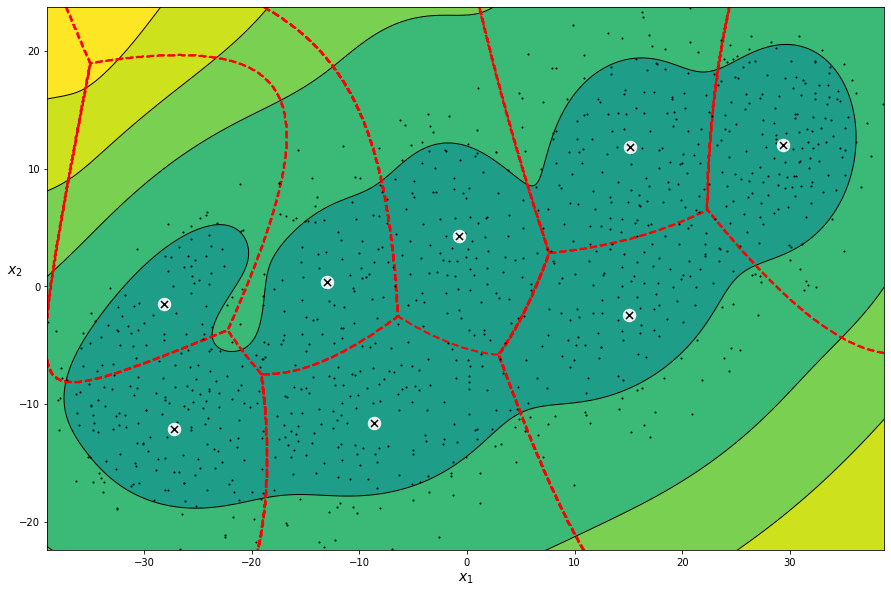

In [278]:
plt.figure(figsize=(15, 10))
plot_gaussian_mixture(gm2d, celeb_2d)
plt.show()

##Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm2d.score_samples(celeb_2d)
density_threshold = np.percentile(densities, 4)
anomalies = celeb_2d[densities < density_threshold]

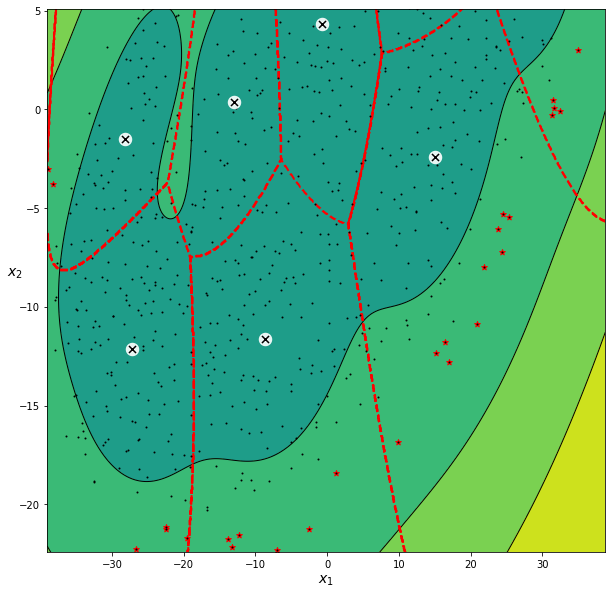

In [280]:
plt.figure(figsize=(10, 10))

plot_gaussian_mixture(gm2d, celeb_2d)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

#Clustering Image-Net Dataset

##Download Dataset

In [281]:
url = 'http://image-net.org/small/train_32x32.tar'
save_path = downsampled_path
download(url,save_path=save_path)

file is being downloading from http://image-net.org/small/train_32x32.tar ...
Done, file in the path data/downsampled/train_32x32.tar


Extract the train_32x32 dataset to the path data/downsampled/imgs/

In [282]:
extractTar(os.path.join(downsampled_path,'train_32x32.tar'),os.path.join(downsampled_path,'imgs'))

Extracting is starting....
Done


##Exploring Data 

list randomly 10 images of the training data

In [283]:
main_path = os.path.join(downsampled_path,'imgs/train_32x32/')

dsp_lst=os.listdir(main_path)
len(dsp_lst)

1281149

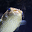

image size (32, 32, 3) 


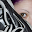

image size (32, 32, 3) 


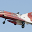

image size (32, 32, 3) 


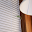

image size (32, 32, 3) 


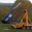

image size (32, 32, 3) 


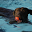

image size (32, 32, 3) 


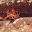

image size (32, 32, 3) 


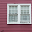

image size (32, 32, 3) 


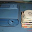

image size (32, 32, 3) 


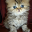

image size (32, 32, 3) 


In [284]:
for i in range(10):
  rndIndx=random.randint(0,len(dsp_lst)-1)
  imgPath = os.path.join(main_path,dsp_lst[rndIndx])
  img=cv2.imread(imgPath)
  cv2_imshow(img)
  print('image size {} '.format(img.shape))
   

##Creating Training Set

In [0]:
downsampled_imgs_folder_path = os.path.join(downsampled_path,'imgs/train_32x32')
dsp_x= create_img_set(downsampled_imgs_folder_path)

In [286]:
len(dsp_x)

1281149

Show randomly 25 images from the training set

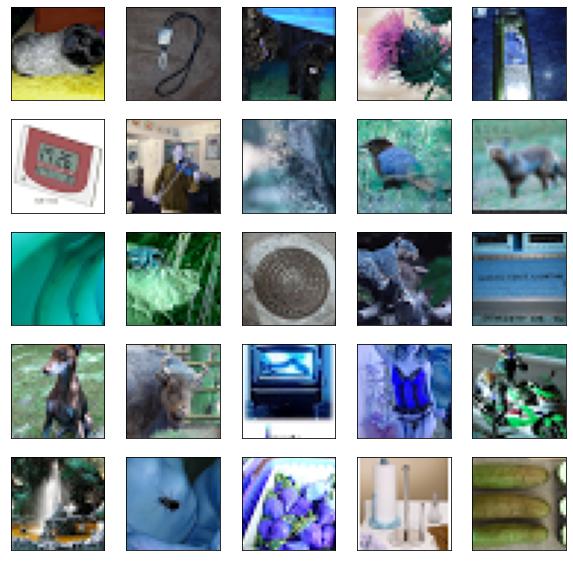

In [287]:
randomly_show_imgs(dsp_x,5,5)

##Flatten the set

convert first the dsp_x from list to numpy array

In [0]:
dsp_x_npa = np.array(dsp_x)

In [298]:
dsp_x_npa.shape

(1281149, 32, 32, 3)

###For sake of experiment speed, random subset size 10000 will be used.

In [299]:
dsp_x_npa = getRandomSubset(dsp_x_npa,1000)

subset (1000, 32, 32, 3)


Convert the data from (1281149, 32, 32, 3) to (1281149, 3072) which is (1281149, 32x32x3)

In [0]:
rows=int(dsp_x_npa.shape[0])
cols=int(dsp_x_npa.shape[1]*dsp_x_npa.shape[2]*dsp_x_npa.shape[3])
dsp_x_npa=dsp_x_npa.reshape(rows,cols)

In [301]:
dsp_x_npa.shape

(1000, 3072)

Scaling Data

In [302]:
dsp_x_npa = dsp_x_npa / 255
dsp_x_npa

array([[0.05882353, 0.06666667, 0.10588235, ..., 0.04313725, 0.07843137,
        0.1254902 ],
       [0.07843137, 0.09411765, 0.13333333, ..., 0.08627451, 0.10196078,
        0.13333333],
       [0.81960784, 0.5254902 , 0.36078431, ..., 0.78039216, 0.83137255,
        0.8627451 ],
       ...,
       [0.06666667, 0.4627451 , 0.81176471, ..., 0.25098039, 0.57647059,
        0.89411765],
       [0.02745098, 0.15686275, 0.2       , ..., 0.28235294, 0.41960784,
        0.35294118],
       [0.15686275, 0.30980392, 0.24313725, ..., 0.21568627, 0.37254902,
        0.36470588]])

###Plot the dataset

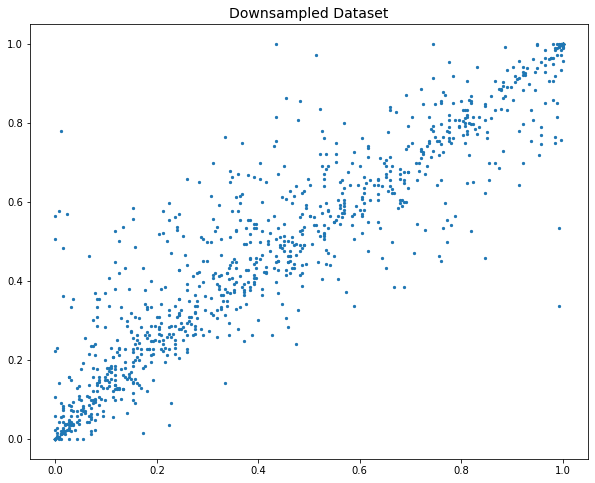

In [303]:
plt.figure(figsize=(10,8))
plt.scatter(dsp_x_npa[:,0],dsp_x_npa[:,1],s=5)
plt.title('Downsampled Dataset',fontsize =14)
plt.show()

### Apply PCA (Variation = 99%)

In [304]:
pca = PCA(0.99)
X_dsp_pca = pca.fit_transform(dsp_x_npa)
pca.n_components_

580

##K-means clustering

Choose random numbers of $k$ to find the best one

In [309]:
k_range = range(2,50,1)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_dsp_pca)
    kmeans_per_k.append(kmeans)

k=2
k=3
k=4
k=5
k=6
k=7
k=8
k=9
k=10
k=11
k=12
k=13
k=14
k=15
k=16
k=17
k=18
k=19
k=20
k=21
k=22
k=23
k=24
k=25
k=26
k=27
k=28
k=29
k=30
k=31
k=32
k=33
k=34
k=35
k=36
k=37
k=38
k=39
k=40
k=41
k=42
k=43
k=44
k=45
k=46
k=47
k=48
k=49


### Plot the silhouette score vs performance of $k$

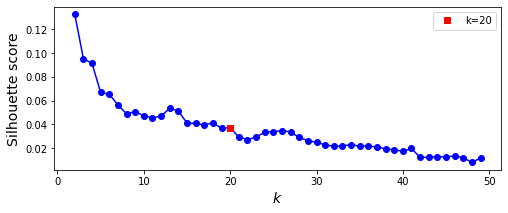

In [314]:
silhouette_scores = [silhouette_score(X_dsp_pca, model.labels_) for model in kmeans_per_k]
best_index = 18
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs",label='k={}'.format(best_k))
plt.legend()
plt.show()

###$k$ = 2 return the highest Sihouette score

In [315]:
best_k

20

##Plot K-Elbow

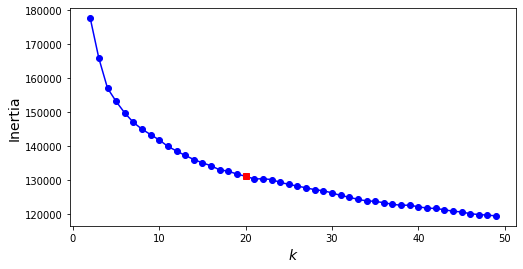

In [317]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs",label='k={}'.format(best_k))
plt.show()

From the elbow the point $k$ = 20 is chosen by us

###Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=best_k, random_state=42)

In [0]:
y_dsp = kmodel.fit_predict(X_dsp_pca)

In [320]:
y_dsp

array([18,  3,  7,  8,  4,  1,  0, 19, 17,  1,  8,  8, 16, 13,  7,  3, 19,
        8, 11, 18, 15,  7, 13, 15,  7, 10,  2, 12, 11, 19, 13, 11,  0,  1,
       12, 15, 15, 10,  1,  2, 15,  2, 18,  7,  7,  6, 13, 15, 12,  8, 15,
       14,  8, 10, 17,  3,  7,  7,  4,  3, 11,  6, 18,  2, 10,  6,  5, 19,
        1,  3, 16, 15,  8, 15,  7, 15, 12, 19, 12, 15,  2, 16,  8,  1,  4,
        6,  3,  7,  2, 17, 17, 19, 13,  1,  7, 11,  3, 11, 12, 16,  1, 17,
       11,  4,  3, 19, 16,  8,  7, 19, 18,  2, 18,  2, 19,  4, 19,  2,  2,
        1, 13, 12,  5,  5,  3, 11,  1, 17, 11,  8, 15,  5,  1,  4,  8, 10,
        0,  4,  3, 12, 17,  1,  1,  1, 15, 19,  6, 10,  1,  2,  7,  6, 12,
       12, 10, 18,  4,  8,  7, 11,  8, 14, 17, 17,  7, 16, 10, 19,  7, 16,
       15,  6,  5, 12,  8,  3, 10,  4,  4,  6, 18,  1,  2, 15,  1,  3,  2,
       13,  1, 17, 19, 13, 18, 11,  4, 10,  1,  0,  2,  2,  3,  3, 17, 10,
        0,  3,  4,  1,  7, 19,  1,  2,  4, 17,  8, 13, 11,  3, 12,  1, 11,
       15,  7,  2,  1, 18

In [321]:
np.unique(y_dsp)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32)

In [322]:
y_dsp is kmodel.labels_

True

Therefore, y_dsp is the label (0, 1,..,19) tha represents for each cluster.


###Plot K-means clusters

In [0]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=best_k, rseed=0, ax=None):

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=y_dsp, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[y_dsp == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

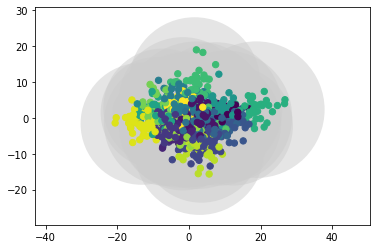

In [324]:
plot_kmeans(kmodel, X_dsp_pca)

In [325]:
dsp_2d = reduceTo2D(dsp_x_npa)
dsp_2d.shape

(1000, 2)

In [327]:
kmodel2d = KMeans(n_clusters=best_k, random_state=42)
kmodel2d.fit(dsp_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

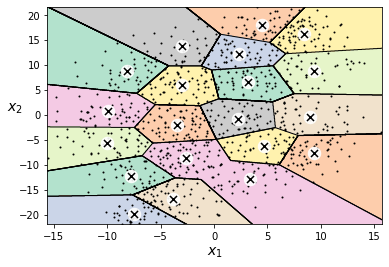

In [328]:
plot_decision_boundaries(kmodel2d,dsp_2d)

##With RandomForest Classifier



###Spliting data for training and testing set in ratio 70%-30%

In [0]:
dsp_x_train, dsp_x_test, dsp_y_train, dsp_y_test = train_test_split(X_dsp_pca, y_dsp, test_size=0.3, shuffle = True, random_state=42)

In [330]:
dsp_x_train.shape, dsp_y_train.shape, dsp_x_test.shape, dsp_y_test.shape

((700, 580), (700,), (300, 580), (300,))


Create the model and fit with the training set

In [331]:
from sklearn.ensemble import RandomForestClassifier

RF_dsp = RandomForestClassifier(random_state=42)
RF_dsp.fit(dsp_x_train, dsp_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [332]:
cross_val_score(RF_dsp, X_dsp_pca, y_dsp, cv=3, scoring='accuracy').mean()

0.39699579819340297

Test the model using testing set

In [335]:
dsp_score_pca=RF_dsp.score(dsp_x_test, dsp_y_test)
dsp_score_pca

0.28

See the predict score

In [336]:
y_pred = RF_dsp.predict(X_dsp_pca)
y_pred

array([18,  3, 12,  7,  4,  1,  0, 19, 17,  7,  1,  8, 16, 13,  7,  3, 19,
        8, 11, 18, 15,  7, 13, 15,  7, 10,  2, 12, 11,  1,  1,  8,  0,  1,
       12, 15, 15, 10,  1, 19, 15,  2, 18,  7,  7,  6, 13, 15, 12,  8, 15,
       14,  8, 10, 17,  1,  7,  7,  4,  3, 11,  6, 18,  2, 10,  1, 17,  1,
        1,  3,  3, 15,  7, 15,  7, 15,  1, 19,  1, 15,  2,  4,  8,  1,  1,
        6,  1,  7,  1, 17, 17, 19, 13,  1,  7, 11,  2,  3, 12, 16,  1,  7,
       11,  4,  3, 19, 16,  7,  7, 19, 15,  2, 18,  2, 19,  4, 19,  2,  3,
        1,  1, 12,  5,  5,  3, 11,  1, 17, 11,  8, 15,  5,  1,  4,  8, 10,
        1,  4,  3,  1, 17,  1,  1,  1, 15, 19,  6, 10,  1,  2,  7,  6, 12,
       12, 10, 15,  4,  8, 17, 11,  8, 14, 17, 17,  7,  1, 10, 19,  8, 16,
       15,  6,  5, 12,  7,  3, 10,  4,  4,  6, 18,  1,  2, 15,  1,  3,  2,
       13,  1, 17, 19, 13, 18, 11,  4, 10,  1,  0,  1,  1,  3,  3, 17, 10,
        1,  3,  4,  1,  8,  3,  1,  2,  4,  4,  8,  1, 11,  3, 12,  1, 11,
        1,  7,  2,  1, 18

In [337]:
accuracy_score(y_dsp, y_pred)

0.784

See the confustion matrix

In [338]:
labels= np.unique(kmodel.labels_)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32)

Text(0.5, 1.0, 'Confusion Matrix')

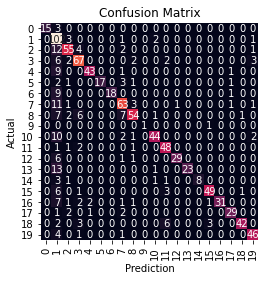

In [339]:
mat = confusion_matrix(y_pred, y_dsp)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

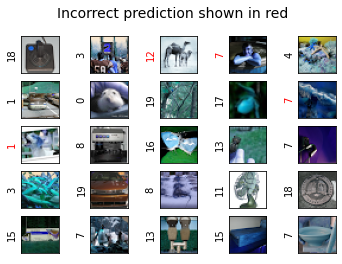

In [340]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(dsp_x[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(str(labels[y_pred[i]]).split()[-1],
                   color='black' if y_pred[i] == y_dsp[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

There are some miss classification

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set


In [0]:
dsp_x_train_np, dsp_x_test_np, dsp_y_train_np, dsp_y_test_np = train_test_split(dsp_x_npa, y_dsp, test_size=0.3, shuffle = True, random_state=42)

In [0]:
best_model = KMeans(n_clusters=best_k, random_state=42)
X_train_reduced = best_model.fit_transform(dsp_x_train_np)
X_test_reduced = best_model.transform(dsp_x_test_np)

In [343]:
X_train_reduced.shape,X_test_reduced.shape

((700, 20), (300, 20))

Perform cross validation using subset size 500

In [344]:
cross_val_score(RF_dsp, X_train_reduced, dsp_y_train_np, cv=3, scoring='accuracy').mean()

0.6099678417274984


Fit to training model

In [345]:
RF_dsp.fit(X_train_reduced, dsp_y_train_np)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [346]:
dsp_score_kmean_reduction=RF_dsp.score(X_test_reduced, dsp_y_test_np)
dsp_score_kmean_reduction

0.68

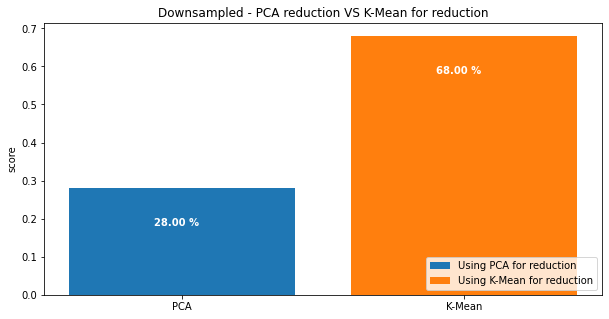

In [358]:
plt.figure(figsize=(10,5))
plt.bar(1,dsp_score_pca,label='Using PCA for reduction')
plt.bar(2,dsp_score_kmean_reduction,label='Using K-Mean for reduction')
plt.xticks([1,2],['PCA','K-Mean'])
plt.text(0.9,dsp_score_pca-0.1,'{:.2f} %'.format(dsp_score_pca*100),color="white", weight='bold')
plt.text(1.9,dsp_score_kmean_reduction-0.1,'{:.2f} %'.format(dsp_score_kmean_reduction*100),color="white", weight='bold')
plt.legend(loc='lower right')
plt.ylabel('score')
plt.title('Downsampled - PCA reduction VS K-Mean for reduction')
plt.show()

There is a big improvment using K-Mean as reduction

##Search for the number of clusters that provides the best performance.

In [348]:
from sklearn.pipeline import Pipeline
#This list to be used for visualization
pipe_dsp_scores = []
for n_clusters in range(1,30):
    pipe_dsp = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    pipe_dsp.fit(dsp_x_train, dsp_y_train)

    pipe_dsp_scores.append([])
    pipe_dsp_scores[n_clusters-1].append(n_clusters)
    score = pipe_dsp.score(dsp_x_test, dsp_y_test)
    pipe_dsp_scores[n_clusters-1].append(score)
    
    print(n_clusters, score)

1 0.08
2 0.2866666666666667
3 0.33
4 0.4166666666666667
5 0.5166666666666667
6 0.5733333333333334
7 0.5466666666666666
8 0.5466666666666666
9 0.58
10 0.5766666666666667
11 0.62
12 0.5933333333333334
13 0.6166666666666667
14 0.5833333333333334
15 0.6133333333333333
16 0.6133333333333333
17 0.64
18 0.64
19 0.6666666666666666
20 0.66
21 0.6566666666666666
22 0.6566666666666666
23 0.6666666666666666
24 0.67
25 0.6566666666666666
26 0.68
27 0.6666666666666666
28 0.6666666666666666
29 0.6533333333333333


In [0]:
pipe_dsp_scores_df = pd.DataFrame(pipe_dsp_scores,columns=['n_cluster','score'])
pipe_dsp_n_clusters = pipe_dsp_scores_df['n_cluster']
pipe_dsp_scores_only = pipe_dsp_scores_df['score']

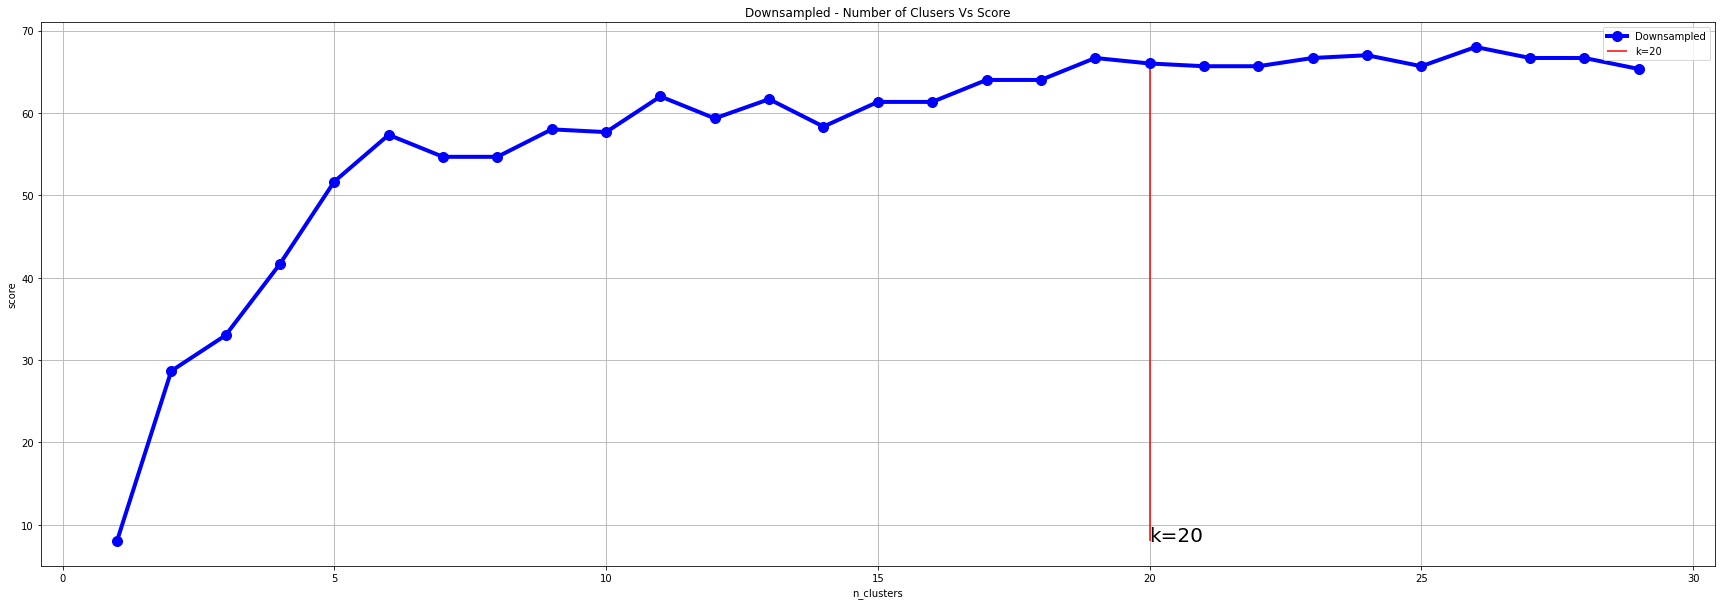

In [355]:
#Plot the chart
linewidth= 4.0
markersize=10.0
plt.figure(figsize=(30,10))
plt.plot(pipe_dsp_n_clusters,pipe_dsp_scores_only*100,'bo-',label='Downsampled',color='blue',linewidth=linewidth, markersize=markersize)
plt.vlines(best_k,np.min(pipe_dsp_scores_only)*100,
           pipe_dsp_scores_only[pipe_dsp_scores_df.n_cluster[pipe_dsp_scores_df.n_cluster == best_k].index]*100,
           label='k={}'.format(best_k),color='red')
plt.text(best_k,np.min(pipe_dsp_scores_only)*100,'k={}'.format(best_k),fontsize=20)
plt.xlabel('n_clusters')
plt.ylabel('score')
plt.title('Downsampled - Number of Clusers Vs Score')
plt.legend()
plt.grid(True)
plt.show()

So n_clusters >= 20 provides almost similar high accuracy for the classifier.

##With Gaussian Mixtures

Plot AIC and BIC as a function as the number of GM to find the best components

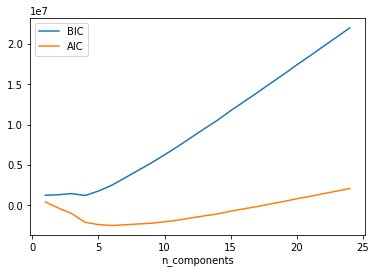

In [357]:
from sklearn.mixture import GaussianMixture

n_components = np.arange(1,25)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_dsp_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_dsp_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_dsp_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

So, n_component = 2 would minimize both BIC and AIC.

Train a Gaussian mixture model on the training set

In [359]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm.fit(dsp_x_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=20, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [360]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [361]:
gm.n_iter_

2

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.


In [362]:
gm.predict(dsp_x_test)

array([ 9,  9,  9, 17,  9,  2, 17, 17, 10,  9,  1, 15, 19,  7, 17,  9,  2,
       17,  1,  5, 17, 17,  1,  9,  9,  5, 19,  5,  1,  7, 17, 15,  9,  9,
        9, 17,  5,  1,  5,  9,  5,  1,  9,  1, 19,  2,  5,  1, 17,  5,  9,
        9,  8,  9, 10,  9,  5,  9,  1,  9,  1, 19,  2, 10,  9,  6, 17,  9,
        1,  9,  5,  9, 17, 17,  1, 15,  9,  1, 15, 17,  1, 17,  9,  9, 17,
        9,  5,  6,  6, 17,  1,  9,  5,  2,  5,  9,  9,  9,  9, 17,  9,  9,
       17,  1,  5,  1, 17, 19,  9,  5, 17,  6,  1,  9,  1,  9, 17,  5,  8,
        9,  2,  1,  5, 15,  9, 17,  9,  5,  9,  1, 17,  5,  9,  9,  1,  1,
        9,  9,  6, 17, 17,  6,  1,  9,  5, 15, 11,  5, 17,  2,  9, 17,  1,
       17,  9,  9, 11,  9,  5,  1,  5,  9,  5, 10,  7,  1,  1, 17, 11,  9,
        5, 15,  5,  9,  9,  1,  6,  9,  5, 17,  1,  9,  5,  5,  5, 16,  9,
       16,  9,  6,  9, 17,  5,  1, 19,  2,  9,  9,  9, 15,  9, 10,  9,  1,
        5, 10, 10,  9,  9,  5,  9,  9,  9,  9,  6,  9,  1,  9,  9,  1,  1,
        4, 11,  9, 17,  9


Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [363]:
gm2d = GaussianMixture(n_components=best_k, n_init=10, random_state=42)
gm2d.fit(dsp_2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=20, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

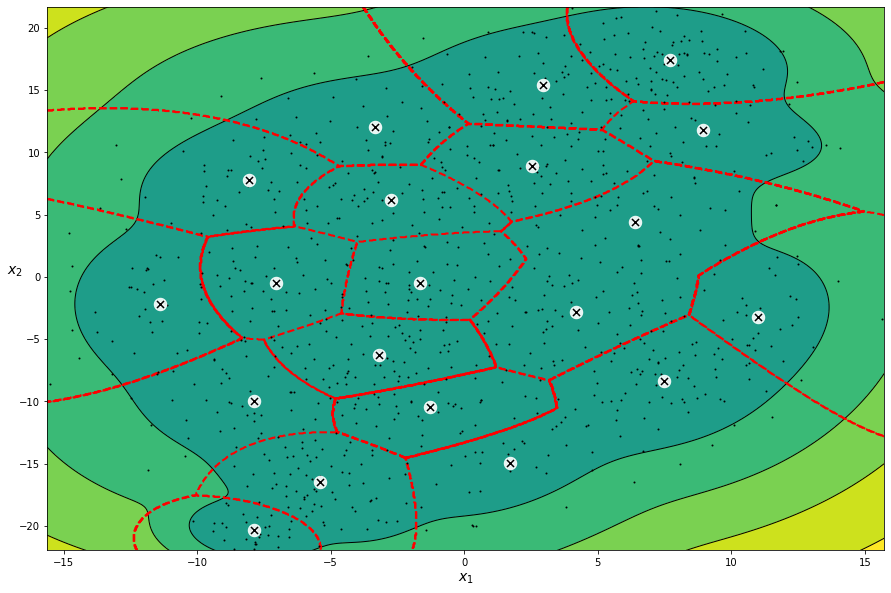

In [364]:
plt.figure(figsize=(15, 10))
plot_gaussian_mixture(gm2d, dsp_2d)
plt.show()

##Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm2d.score_samples(dsp_2d)
density_threshold = np.percentile(densities, 4)
anomalies = dsp_2d[densities < density_threshold]

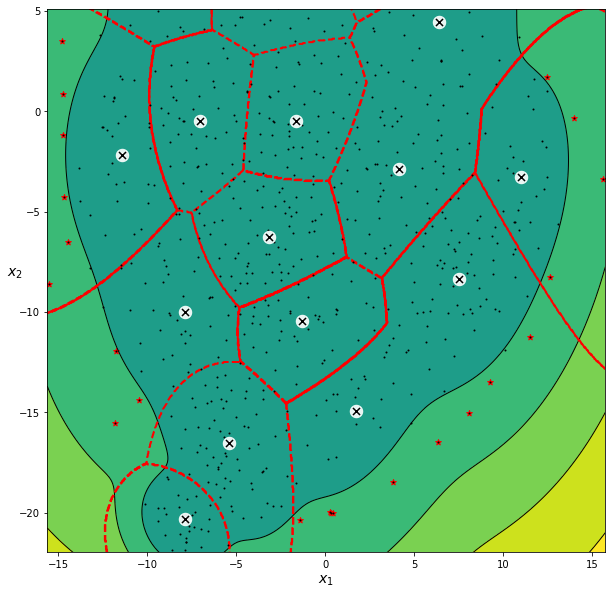

In [366]:
plt.figure(figsize=(10,10))

plot_gaussian_mixture(gm2d, dsp_2d)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

# Summary Chart n_clusters vs classifier performance


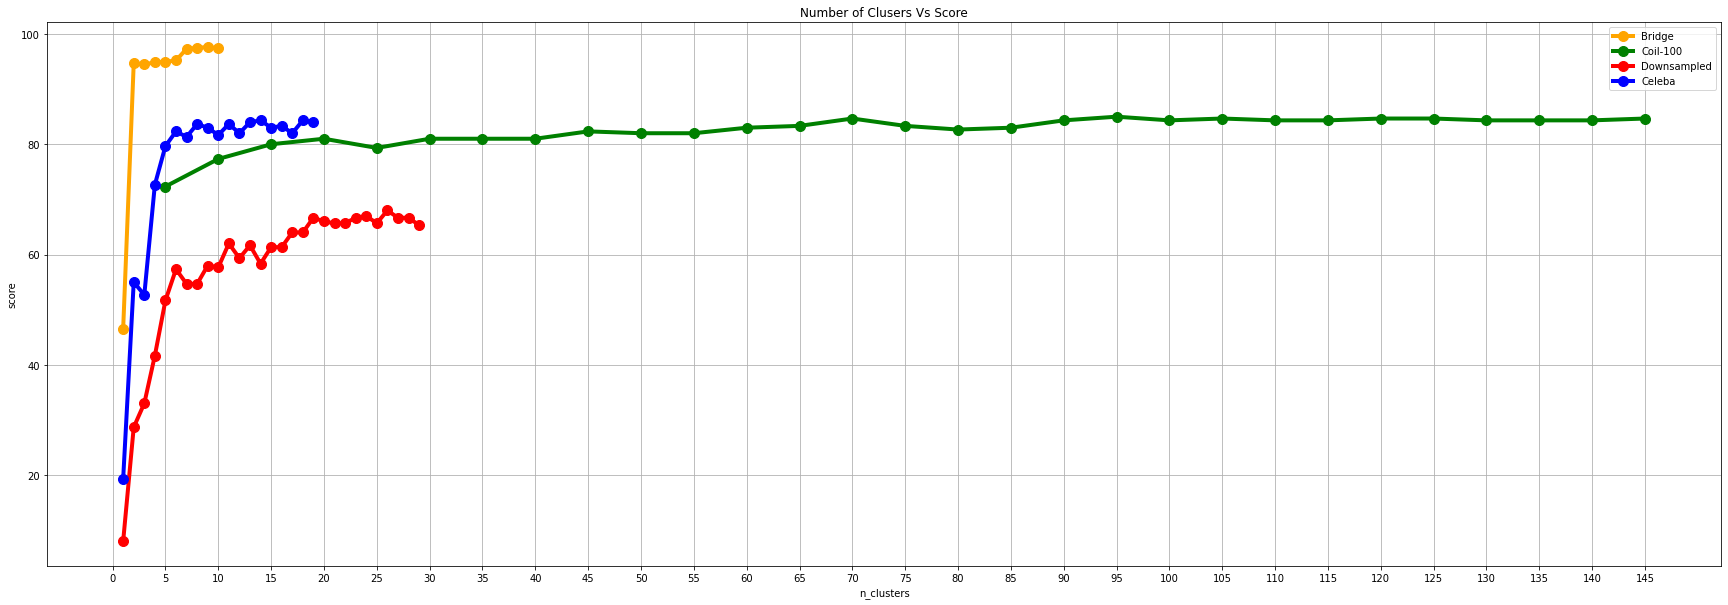

In [367]:
#Plot the chart
linewidth= 4.0
markersize=10.0
plt.figure(figsize=(30,10))
plt.plot(pipe_bridge_n_clusters,pipe_bridge_scores_only*100,'bo-',label='Bridge',color='orange',linewidth=linewidth, markersize=markersize)
plt.plot(pipe_coil100_n_clusters,pipe_coil100_scores_only*100,'bo-',label='Coil-100',color='green',linewidth=linewidth, markersize=markersize)
plt.plot(pipe_dsp_n_clusters,pipe_dsp_scores_only*100,'bo-',label='Downsampled',color='red',linewidth=linewidth, markersize=markersize)
plt.plot(pipe_clb_n_clusters,pipe_clb_scores_only*100,'bo-',label='Celeba',color='blue',linewidth=linewidth, markersize=markersize)
plt.xlabel('n_clusters')
plt.ylabel('score')
plt.title('Number of Clusers Vs Score')
plt.xticks(range(0,150,5))
plt.legend()
plt.grid(True)
plt.show()

#Conclusion


*   Each dataset have different size and format, and 70% of the majority works and time is to load and clean those huge size datasets.
*   Dimensionality reduction PCA provides classifier's performance better than k-means, but not so much different.
*   Selecting n_clusters ($k$) is still in a gray area since there's no global theory on how to determine $k$; however, by plotting elbow of $k$ could give us a scense of picking a good number of clusters. Once again, this elbow method is not 100% accurate to determine $k$.`
*   For sake of experiment speed, only RandomForest classifier was used with small subsets of the datasets.
*   Slicing n_clusters to see the differences of classifier's performance, defenely a great intuitive to let you choose one that can minimize your learning speed and maximize the learning performance.
*   Below is the summary chart of n_clusters vs classifier's performance, generated from Tableau.







#Refrences

https://nbviewer.jupyter.org/github/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb

https://stackoverflow.com/questions/16760992/how-to-download-a-zip-file-from-a-site-python

https://stackabuse.com/download-files-with-python/

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html